# <center> PRÁCTICA 3: ANÁLISIS MULTIVARIANTE I Y II <center>

<center> Covadonga Galán Fernández <center>

In [1]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy.ma as ma
import numpy.linalg as linalg
from scipy.stats.stats import pearsonr

# Estadística
from scipy import stats 
from scipy import special
from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p


import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')


In [2]:
# DEFINIMOS LAS FUNCIONES QUE SE VAN A USAR EN EL PROGRAMA

def region2(data,lat,lon,lonmin,lonmax,latmin,latmax):
    # data[t,lon,lat]
    latc=lat[(lat>=latmin)&(lat<=latmax)]
    lonc=lon[(lon>=lonmin)&(lon<=lonmax)]
    datac = data[:,:,(lon>=lonmin)&(lon<=lonmax)][:,(lat>=latmin)&(lat<=latmax),:]
    return datac,latc,lonc
    
def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

def region(A,lon,lat,lonmin,lonmax,latmin,latmax):
    nt, nlat, nlon = A.shape
    #lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
    AN = A[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
    lon_AN= lon[(lon>lonmin)&(lon<lonmax)]
    lat_AN=lat[(lat>latmin)&(lat<latmax)]
    return lat_AN, lon_AN, AN

def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(
        X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    #Index tiene que estar estandarizado, es decir, dividido por la desviación tipica
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig

def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2);
    ax.set_title(titulo,fontsize=28)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.7, format="%2.1f")
    cbar.set_label(l1, size=28)
    cbar.ax.tick_params(labelsize=28) 
# Esta función te sirve para dibujar en una misma figura dos mapas superpuestos, como podría ser
# el caso de un mapa A de regresion y un mapa B de correlacion significativa, del que solo te interesa
# las regiones donde es significativa la señal
def dibujo_2_mapas_cartopy_hatches(A,B,lon,lat, levs, cmap1, l1, t1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
    
    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon)), 
                     extend='both',cmap=cmap1,levels=levs,transform = ccrs.PlateCarree())

    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores
    im = ax.contourf(lon,lat,B.reshape(len(lat),len(lon))
                 ,extend='both'
                 ,hatches='.',cmap=cmap1,alfa=0,levels=levs,transform = ccrs.PlateCarree())
    #el uso de alfa=0 lo que hace es que solo salgan los puntos y no salgan los colors porque los pones totalmente transparentes
    ax.set_ylim(lat[-1], lat[0])
    ax.set_xlim(lon[0], lon[-1])

def regresLinSim(x,y):
    alpha = 0.05
    x = np.squeeze(np.array(x))
    y = np.squeeze(np.array(y))
    N = x.size
    xm = x.mean()
    ym = y.mean()
    SXY = np.sum(x * y) - N * xm * ym
    SXX = np.sum(x * x) - N * xm * xm
    SYY = np.sum(y * y) - N * ym * ym
    SSR = SXY ** 2 / SXX 
    a1 = SXY / SXX
    a0 = ym - xm * a1
    yhat =  a0 + a1 * x
    e = y - yhat
    R2 = SSR / SYY
    SSE = SYY - SSR
    rho = SXY / np.sqrt(SXX*SYY)
    Se = np.sqrt( SSE / (N - 2 ) )
    t = stats.t.ppf(1-alpha/2,N-2)
    IC_a1 = a1 + np.array([-1, 1]) * t * Se / np.sqrt(SXX)
    IC_a0 = a0 + np.array([-1, 1]) * t * Se * np.sqrt(np.sum(x*x)/N/SXX)
    xvec = np.linspace(x.min(),x.max(),100)
    muY = ym + a1 * (xvec - xm) 
    AmuY = t * Se * np.sqrt(1/N + (xvec-xm) * (xvec -xm) /SXX)
    AY = t * Se * np.sqrt( 1 + 1/N + (xvec-xm) * (xvec -xm) /SXX)
    fig,ax = plt.subplots(1,2,figsize=(18,8))
    ax[0].plot(x,y,'o',markeredgecolor='black',markeredgewidth=1)
    #ax[0].grid()
    ax[0].plot(xvec,muY+AmuY,color='orange')
    ax[0].plot(xvec,muY-AmuY,color='orange')
    ax[0].plot([x.min(), x.max()],[a0+a1*x.min(), a0+a1*x.max()],'r')
    ax[0].plot(xvec,muY+AY,color='k')
    ax[0].plot(xvec,muY-AY,color='k')
    ax[0].set_title('Simple Linear Regression')
    ax[0].set_ylabel('y')
    ax[0].set_xlabel('x')
    ax[0].text(0.5,0.05,r'$a_0$=[%.3f,%.3f]''\n'r'$a_1$=[%.3f,%.3f]''\n'r'$\rho =$ %.2f'%(IC_a0[0],IC_a0[1],IC_a1[0],IC_a1[1],rho), 
                transform=ax[0].transAxes,size=11,bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))
    #ax[0].text(0.5,0.1,'a1=[%.3f,%.3f]'%(IC_a1[0],IC_a1[1]), transform=ax[0].transAxes)
    #ax[0].text(0.5,0.15,'rho=%.2f'%(rho), transform=ax[0].transAxes)
    ax[1].plot(yhat,e/Se,'o',markeredgecolor='black',markeredgewidth=1)
    #ax[1].grid()
    ax[1].set_xlabel(r'$\hat{y}$')
    ax[1].set_ylabel(r'$\hat{e}/\sigma_E$')
    ax[1].set_title('Standardized residuals')
    return ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY

def MCA(Z,Y,nmes,nm,meth,alfa,sig,perm):
     # Z: campo a predecir
    # Y: campo predictor
    # datos con dimensiones ns, nt
    # nm: numero de modos
    # nmes: meses por año, si es media estacional es 1, pero si es enero y feb
    #por separado es 2
    # meth: metodología
    # Y1, Z1: campos sobre los que proyecto los resultados, 
    #que pueden ser para un espacio mayor que en Z e Y
    
    nz,nt=Z.shape
    ny,nt=Y.shape
    nyr=int(nt/nmes)
    # matriz de covarianza
    if  meth=='MCA':
        C=np.dot(Y,np.transpose(Z))
    
    if  meth =='CCA':
        iSYY=inv(np.dot(Y,np.transpose(Y)))
        SYZ=np.dot(Y,np.transpose(Z))
        iSZZ=inv(np.dot(Z,np.transpose(Z)))
        SZY=np.dot(Z,np.transpose(Y))
        C=np.dot(np.dot(iSYY,SYZ), np.dot(iSZZ,SZY))
    
    R,d,Q=linalg.svd(C) # R son los autovectores de y Q son los autovectores de Z
    scf=d/np.sum(d)
    

    # coefs de expansión
    U=np.dot(np.transpose(Y),R[:,:nm])
    V=np.dot(np.transpose(Z),Q[:,:nm])
    
    # coefs de expansión estandarizados
    Us=anom(np.transpose(U),nyr,'st')
    Vs=anom(np.transpose(V),nyr,'st')
    
    RUY=ma.empty([ny,nm]);pvalruy=ma.empty([ny,nm]);RUY_sig=ma.empty([ny,nm]);SUY=ma.empty([ny,nm]);SUY_sig=ma.empty([ny,nm])
    RUZ=ma.empty([nz,nm]);pvalruz=ma.empty([nz,nm]);RUZ_sig=ma.empty([nz,nm]);SUZ=ma.empty([nz,nm]);SUZ_sig=ma.empty([nz,nm])
    for i in range(nm):
        RUY[:,i], pvalruy[:,i], RUY_sig[:,i], SUY[:,i], SUY_sig[:,i]=IndexRegrCorr(Y,Us[i,:],alfa,sig,perm)
        RUZ[:,i], pvalruz[:,i], RUZ_sig[:,i], SUZ[:,i], SUZ_sig[:,i]=IndexRegrCorr(Z,Us[i,:],alfa,sig,perm)

    return RUY,RUY_sig,SUY,SUY_sig,RUZ,RUZ_sig,SUZ,SUZ_sig,Us,Vs,scf


def dibujo_timeserie(ax,TS,time,ylabel,xlabel,title):
    ax.plot(time,TS,linewidth=6)
    ax.grid(b=True, linestyle ='--')
    plt.xticks(np.arange(time[0],time[-1],20))
    ax.tick_params('y',labelsize = 14, width = 2, length = 10)
    ax.tick_params('x',labelsize = 12, width = 2, length = 10, labelrotation = 60)
    ax.legend(loc=3,fontsize=14)
    ax.set_title(title, fontsize = 16, weight ='bold')
    ax.set_ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 14, fontweight = 'bold')


def dibujo_timeserie_confiltro(ax,time,sig,low,low_det,high,xlabel,ylabel,title):
    ax.plot(time,sig,label ='raw')
    ax.plot(time,low,label ='low')
    ax.plot(time,high,label ='high')
    ax.plot(time,low_det,label ='low_det')
    ax.grid(b=True, linestyle ='--')
    plt.xticks(np.arange(time[0],time[-1],20))
    ax.tick_params('y',labelsize = 14, width = 2, length = 10)
    ax.tick_params('x',labelsize = 12, width = 2, length = 10, labelrotation = 60)
    ax.legend(loc=3,fontsize=14)
    ax.set_title(title, fontsize = 16, weight ='bold')
    ax.set_ylabel(ylabel, fontsize = 14, fontweight = 'bold')
    ax.set_xlabel(xlabel, fontsize = 14, fontweight = 'bold');


def filtro(nyc,n,Wn,TS):
#Wn= 2*dt/nyc
    b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
    #Filtro la señal ampliada y me quedo con la parte central:
    low = signal.filtfilt(b,a,TS)
    b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
    #Filtro la señal ampliada y me quedo con la parte central:
    high = signal.filtfilt(b,a,TS)
    return high,low

def crossvalidation(Y,Z,nmes,nm,alfa,sig,perm):
    '''
    Técnica utilizada para predicción que se explicará más adelantes
    '''
    #Y campo predictor
    # Z campo a predecir
    # nmes: numero de tiempos por año (numero de meses o de días), normalmente es 1 porque se hacen promedios estacionales
    # alfa: nivel de significacion: 0.01,0.05,0.1
    #sig: "t-test" si la significacion de los modos se hace por un test de independencia de caracteres con test-t, "MonteCarlo", 
    #si se hace con un test no paramétrico de MonteCarlo con un número perm de permutaciones (100, 200 etc..)
    
    nz,nt = Z.shape
    ny,nt = Y.shape
    
    Zhat = ma.empty_like(Z)
    scf = ma.empty([ny,nt])
    ruv = ma.empty([nm,nt])
    pruv = ma.empty([nm,nt])
    # estimación de Zhat para cada año
    yrs=np.linspace(1,nt,nt)
    for i in range(nt):
        print(i)
        z2 = Z[:,yrs!=i]
        y2 = Y[:,yrs!=i]
        RUY,RUY_sig,SUY,SUY_sig,RUZ,RUZ_sig,SUZ,SUZ_sig,Us,Vs,scf[:,i] = MCA(z2,y2,nmes,nm,'MCA',alfa,sig,perm)
        PSI=np.dot(np.dot(np.dot(SUY,linalg.inv(np.dot(Us,np.transpose(Us)))),Us),np.transpose(z2))*nt*nm/ny 
        Zhat[:,i] = np.dot(np.transpose(Y[:,i]),PSI)
        for m in range(nm):
            ruv[m,i],pruv[m,i] = pearsonr(Us[m,:],Vs[m,:])
    
    r = np.zeros(nt)       
    for j in range(nt):
        r[j] = pearsonr(Zhat[:,j],Z[:,j])[0] # serie de skill
      
    rs = np.zeros(nz) 
    rs_sig = np.zeros(nz) 
    rmse = np.zeros(nz)
  
    for j in range(nz):
        rs[j] = pearsonr(Zhat[:,j],Z[:,j])[0] # serie de skill
  
        
    return Zhat,scf,ruv,r

--------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------

# <CENTER> PARTE 3 <CENTER>

---------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Cargo los datos de la matríz de los índices de extremos calculados 
# para toda España, hechos en la práctica 2
path='/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/Practica 3/Datos/'
varitn10='Tn10p_ESP_nan.nc'
varitx10='Tx10p_ESP_nan.nc'
tn10 = xr.open_dataset(path+varitn10)
tx10 = xr.open_dataset(path+varitx10)

In [4]:
# Obtenemos las variables del data array 
tn10=tn10.__xarray_dataarray_variable__
tx10=tx10.__xarray_dataarray_variable__

In [5]:
# Vamos a hacer el remallado de las matrices para disminuir el número de datos
tn10_remallado=tn10.interp(lat=tn10.lat[::2]).interp(lon=tn10.lon[::2])
tn10_remallado=tn10_remallado.set_index(lon='x')
tn10_remallado=tn10_remallado.set_index(lat='y')

tx10_remallado=tx10.interp(lat=tx10.lat[::2]).interp(lon=tx10.lon[::2])
tx10_remallado=tx10_remallado.set_index(lon='x')
tx10_remallado=tx10_remallado.set_index(lat='y')

lon = tn10_remallado.lon
lat = tn10_remallado.lat
time=tx10_remallado.time


In [6]:
lat

<xarray.DataArray 'lat' (lat: 95)>
array([44.169965, 44.079965, 43.989965, 43.899965, 43.809965, 43.719965,
       43.629965, 43.539965, 43.449965, 43.359965, 43.269965, 43.179965,
       43.089965, 42.999965, 42.909965, 42.819965, 42.729965, 42.639965,
       42.549965, 42.459965, 42.369965, 42.279965, 42.189965, 42.099965,
       42.009965, 41.919965, 41.829965, 41.739965, 41.649965, 41.559965,
       41.469965, 41.379965, 41.289965, 41.199965, 41.109965, 41.019965,
       40.929965, 40.839965, 40.749965, 40.659965, 40.569965, 40.479965,
       40.389965, 40.299965, 40.209965, 40.119965, 40.029965, 39.939965,
       39.849965, 39.759965, 39.669965, 39.579965, 39.489965, 39.399965,
       39.309965, 39.219965, 39.129965, 39.039965, 38.949965, 38.859965,
       38.769965, 38.679965, 38.589965, 38.499965, 38.409965, 38.319965,
       38.229965, 38.139965, 38.049965, 37.959965, 37.869965, 37.779965,
       37.689965, 37.599965, 37.509965, 37.419965, 37.329965, 37.239965,
       37.149965, 37.059965, 36.969965, 36.879965, 36.789965, 36.699965,
       36.609965, 36.519965, 36.429965, 36.339965, 36.249965, 36.159965,
       36.069965, 35.979965, 35.889965, 35.799965, 35.709965])
Coordinates:
  * lat      (lat) float64 44.17 44.08 43.99 43.9 ... 35.98 35.89 35.8 35.71

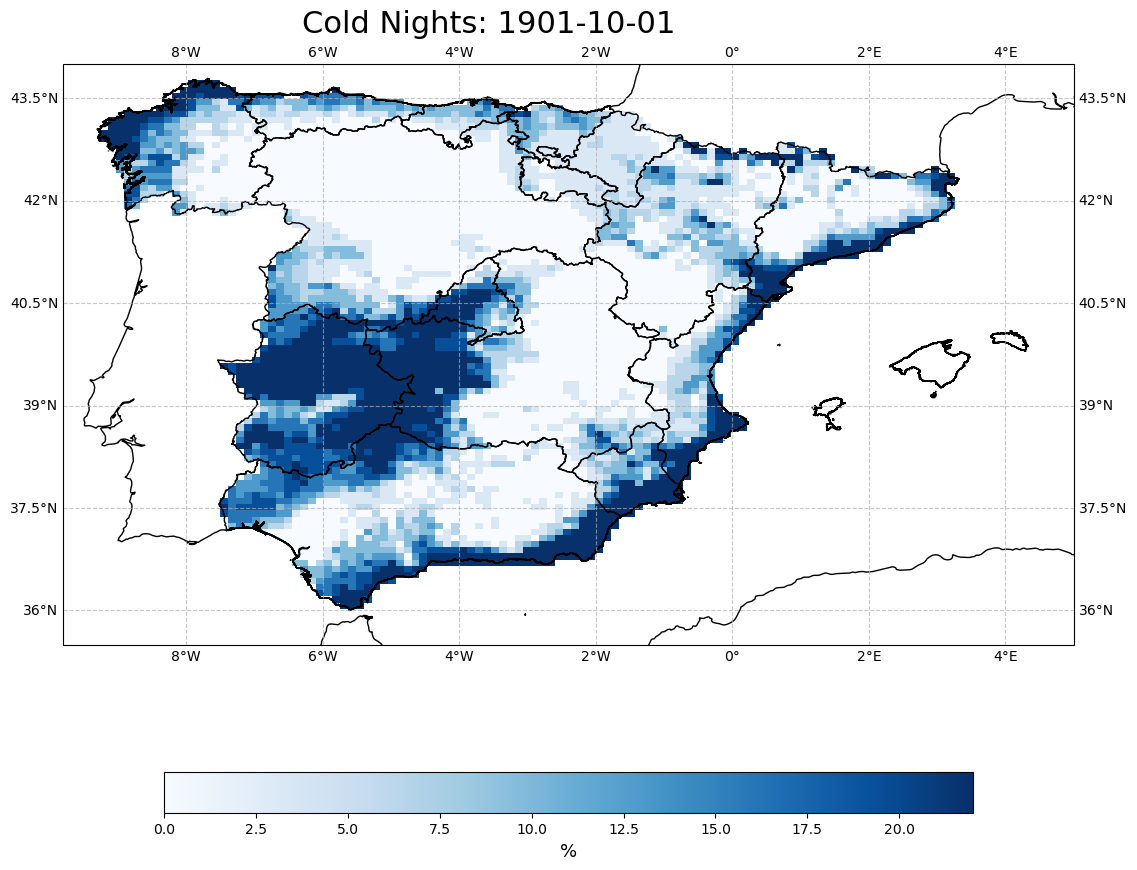

In [7]:
# Representamos un día de ejemplo para comprobar 
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = '../Practica 2/Codigos/Diego/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

# A partir de aquí vamos a pintar los valores promedio de noches frías en el periodo empleado   
cmap = 'Blues'
fecha='1901-10-01'
var = tn10_remallado.sel(time=fecha)
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 
#print(var.max().squeeze())

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot

plt.suptitle('Cold Nights: '+str(fecha),size=22)

# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8) 
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22) # Al poner los mismos vmin y vmax aseguramos que la escala sea consistente en cada parte

plt.tight_layout()

In [8]:
nlon=lon.shape[0]
nlat=lat.shape[0]
nt=time.shape[0]

nyears= int(nt/12)
nyears

114

In [9]:
#Agrupamos por meses para sacar la estacion que tiene mayor variabilidad, que en nuestro caso es PRIMAVERA
# ya que en la práctica 2 se vio que era donde había más picos significativos en las regiones.
tn10_primavera=tn10_remallado.groupby('time.season')['MAM']

tx10_primavera=tx10_remallado.groupby('time.season')['MAM']


In [10]:
nm = 12
nyears = int(tn10_primavera.time.shape[0]/nm)

In [11]:
# Calculamos la anomalía de las matrices 

# NOCHES FRÍAS
tn10_primavera_anomalia= tn10_primavera-tn10_primavera.mean(axis=0)
[nt,nlat,nlon]=tn10_primavera_anomalia.shape
tn10_primavera_anomalia=np.reshape(np.array(tn10_primavera_anomalia), (int(nt/3),3,nlat,nlon)).mean(axis=1)
tn10_primavera_anomalia.shape

# DÍAS FRÍOS
tx10_primavera_anomalia= tx10_primavera-tx10_primavera.mean(axis=0)
[nt,nlat,nlon]=tx10_primavera_anomalia.shape
tx10_primavera_anomalia=np.reshape(np.array(tx10_primavera_anomalia), (int(nt/3),3,nlat,nlon)).mean(axis=1)
tx10_primavera_anomalia.shape


(114, 95, 115)

In [12]:
# Primero hay que poner los datos como una matriz (tiempo,espacio), para poder correr las funciones
tn10_prim_nans=np.reshape(tn10_primavera_anomalia,(114,nlat*nlon))
tx10_prim_nans=np.reshape(tx10_primavera_anomalia,(114,nlat*nlon))

tn10_prim_nans.shape

(114, 10925)

In [13]:
# Ahora vamos a quitar los nans 
tn10_primavera_sin_nan=quitonans(tn10_prim_nans)
tx10_primavera_sin_nan=quitonans(tx10_prim_nans)
tn10_primavera_sin_nan.shape
# Ahora tenemos una matriz TIEMPO ESPACIO sin los valores nan

(114, 5049)

---

## <center> NOCHES FRÍAS <center>

---

In [14]:
C_N=np.dot(np.transpose(tn10_primavera_sin_nan),tn10_primavera_sin_nan)
# C tiene que ser una matriz ESPACIO-ESPACIO

In [15]:
C_N.shape
# Vemos que tiene dimensiones espacio espacio

(5049, 5049)

In [16]:
eof_tn10,d_tn10,eof2_tn10=linalg.svd(C_N)
# El campo derecho y el izquierdo tienen la misma dimensión, cualquiera de los dos dará lo mismo
# Se tendrá una matriz diagonal con las dimesniones del espacio, solo interesan los primeros autovalores

In [17]:
fvar_tn10=(d_tn10)/sum(d_tn10)

sum(fvar_tn10[:10])

# Los 10 primeros autovalores nos dan el 85 % de la variabilidad

0.8477085457049081

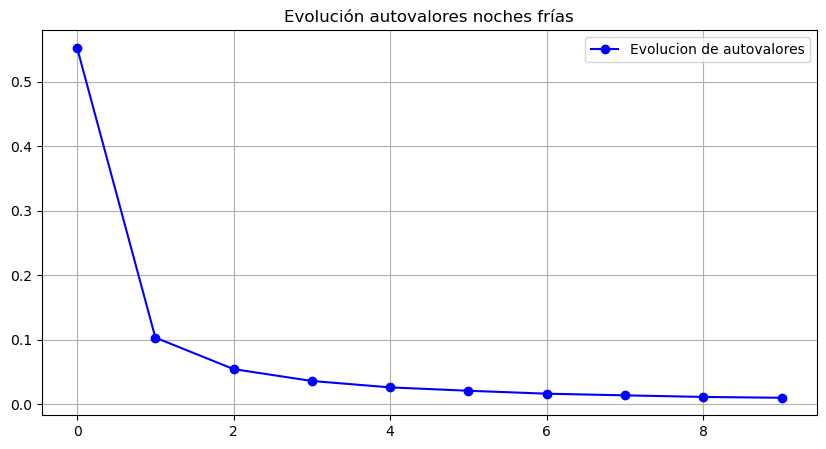

In [18]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar_tn10[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.title('Evolución autovalores noches frías')
plt.legend()
plt.grid()

In [19]:
PC_N=np.dot(tn10_primavera_sin_nan,eof_tn10[:,:8])
PC_N.shape

(114, 8)

In [20]:
PCs_N=(PC_N-np.mean(PC_N))/np.std(PC_N)

Text(0.5, 1.0, 'Noches frías: Primera componente principal fvar=0.55')

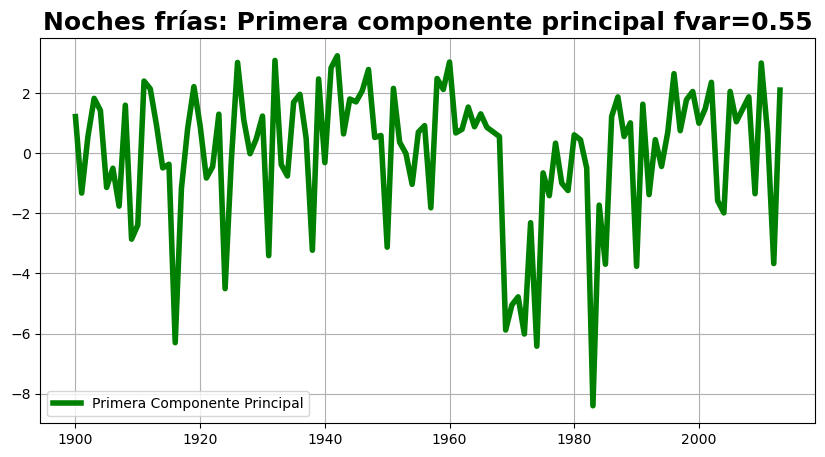

In [21]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs_N[:,0],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Noches frías: Primera componente principal fvar='+ str( round(fvar_tn10[0],2)),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Segunda componente principal fvar=0.1')

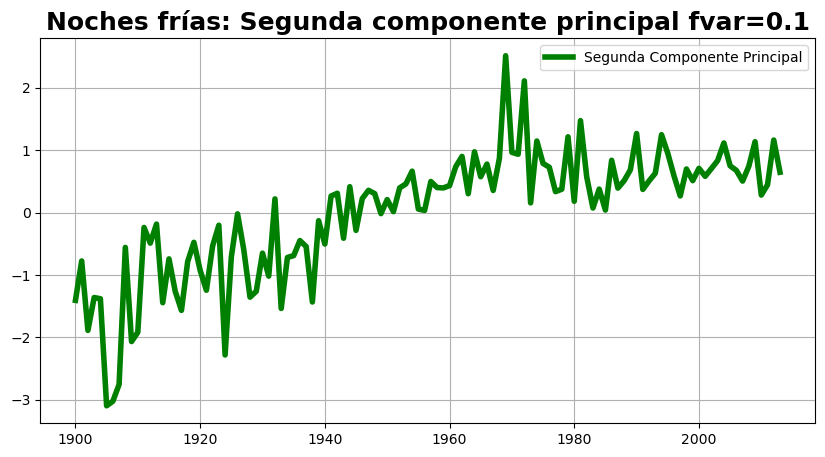

In [22]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs_N[:,1],linewidth= 4,color='green',label='Segunda Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Noches frías: Segunda componente principal fvar='+ str( round(fvar_tn10[1],2)),fontsize=18,weight='bold')


Text(0.5, 1.0, 'Noches frías: Tercera componente principal fvar=0.05')

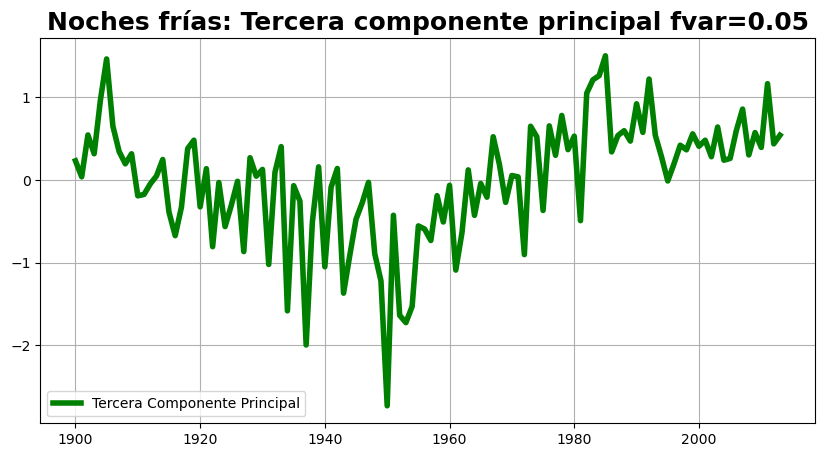

In [23]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs_N[:,2],linewidth= 4,color='green',label='Tercera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Noches frías: Tercera componente principal fvar='+ str( round(fvar_tn10[2],2)),fontsize=18,weight='bold')


In [24]:
nyc=12
n=10
Wn=2*1/nyc
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(b,a,PCs_N[:,0])

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCs_N[:,0])

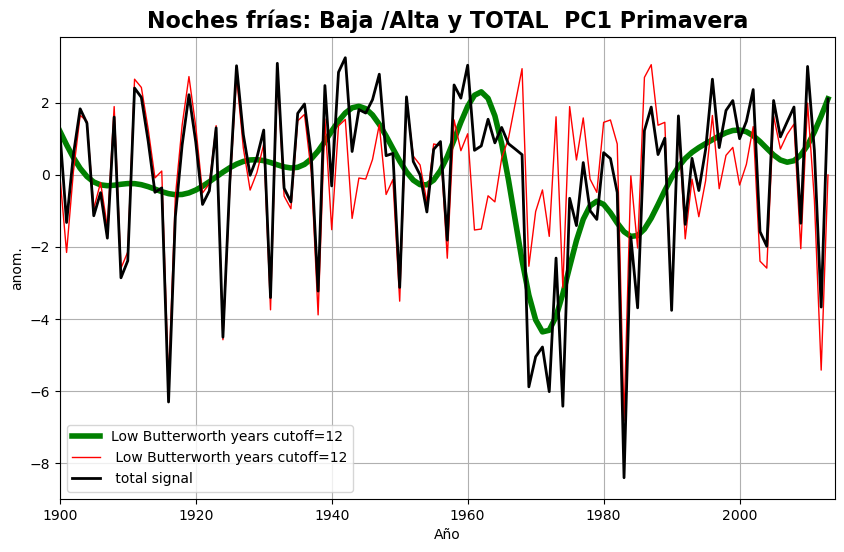

In [25]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Noches frías: Baja /Alta y TOTAL  PC1 Primavera',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom.')
ax.plot(range(1900,2014),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),PCs_N[:,0],linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1900,2014])
ax.legend()
ax.grid()

In [26]:
nyc=12
n=10
Wn=2*1/nyc
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(b,a,PCs_N[:,2])

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCs_N[:,2])

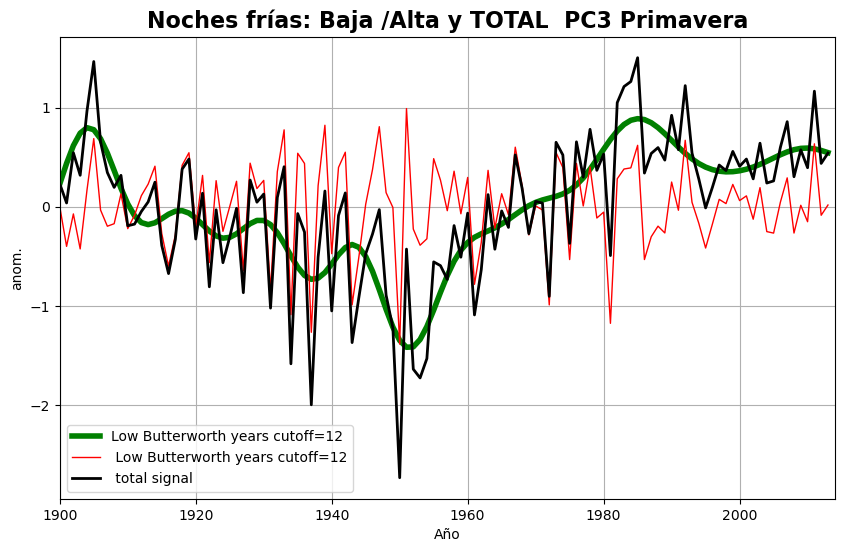

In [27]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Noches frías: Baja /Alta y TOTAL  PC3 Primavera',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom.')
ax.plot(range(1900,2014),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),PCs_N[:,2],linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1900,2014])
ax.legend()
ax.grid()

In [28]:
cor1,Pvalue1,cor_sig1,reg1,reg1_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs_N[:,0]),0.1,'MonteCarlo',100)
cor2,Pvalue2,cor_sig2,reg2,reg2_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs_N[:,1]),0.1,'MonteCarlo',100)
cor3,Pvalue3,cor_sig3,reg3,reg3_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs_N[:,2]),0.1,'MonteCarlo',100)
cor4,Pvalue4,cor_sig4,reg4,reg4_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs_N[:,3]),0.1,'MonteCarlo',100)
cor5,Pvalue5,cor_sig5,reg5,reg5_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs_N[:,4]),0.1,'MonteCarlo',100)
cor6,Pvalue6,cor_sig6,reg6,reg6_sig=IndexRegrCorr(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs_N[:,5]),0.1,'MonteCarlo',100)


In [29]:
mat=np.expand_dims((tn10_primavera)[0],axis=0)

In [30]:
reg1_final=pongonans(np.squeeze(reg1),mat)
reg_sig_1_final=pongonans(np.squeeze(reg1_sig),mat)

cor1_final=pongonans(np.squeeze(cor1),mat)
cor_sig1_final=pongonans(np.squeeze(cor_sig1),mat)

reg2_final=pongonans(np.squeeze(reg2),mat)
reg_sig_2_final=pongonans(np.squeeze(reg2_sig),mat)

cor2_final=pongonans(np.squeeze(cor2),mat)
cor_sig2_final=pongonans(np.squeeze(cor_sig2),mat)

reg3_final=pongonans(np.squeeze(reg3),mat)
reg_sig_3_final=pongonans(np.squeeze(reg3_sig),mat)

cor3_final=pongonans(np.squeeze(cor3),mat)
cor_sig3_final=pongonans(np.squeeze(cor_sig3),mat)

reg4_final=pongonans(np.squeeze(reg4),mat)
reg_sig_4_final=pongonans(np.squeeze(reg4_sig),mat)

reg5_final=pongonans(np.squeeze(reg5),mat)
reg_sig_5_final=pongonans(np.squeeze(reg5_sig),mat)

reg6_final=pongonans(np.squeeze(reg6),mat)
reg_sig_6_final=pongonans(np.squeeze(reg6_sig),mat)

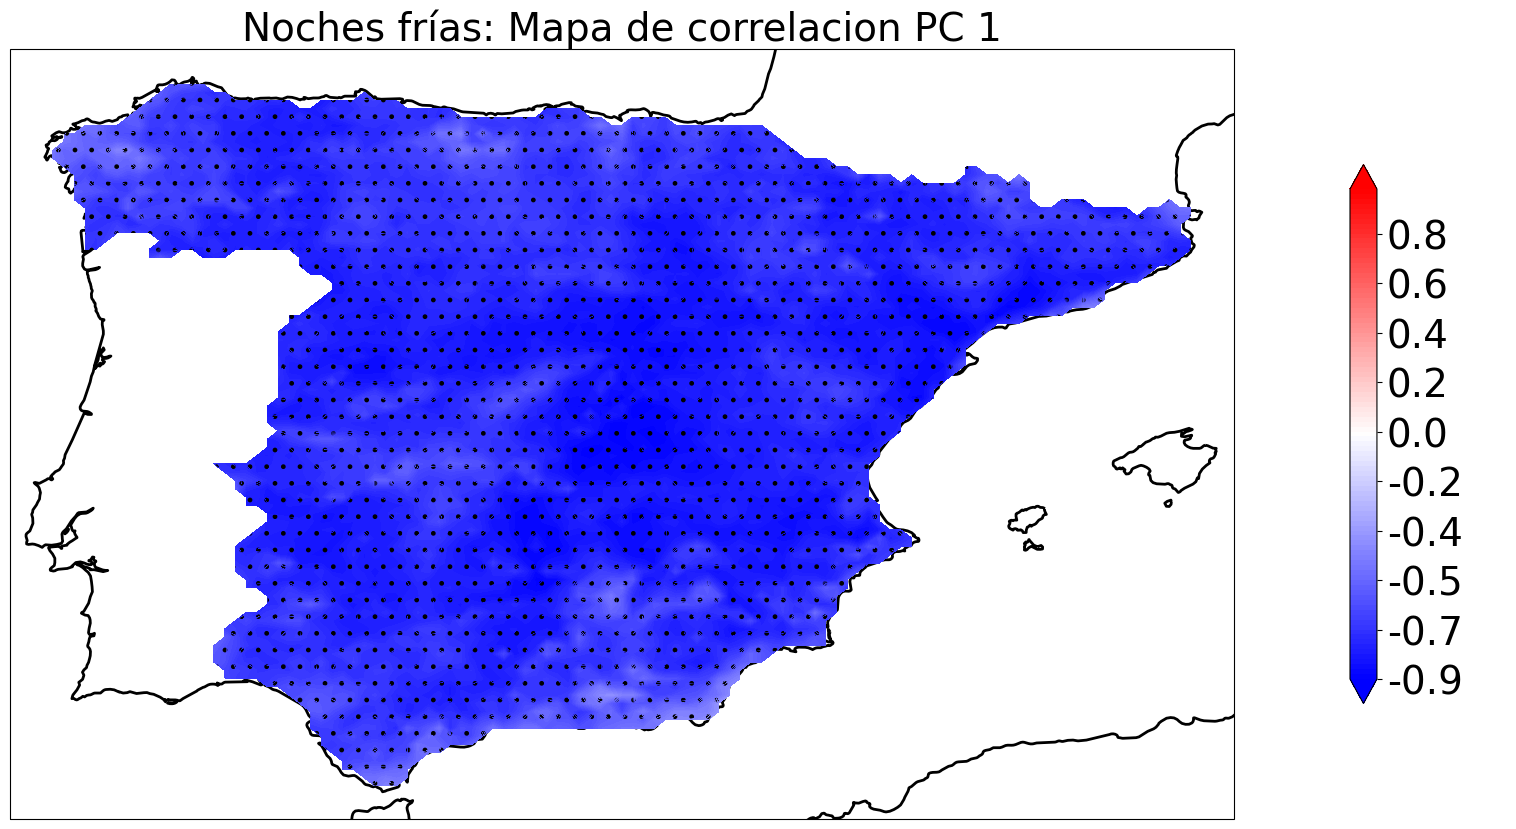

In [31]:
rango_reg=max(abs(np.nanmin(cor1_final)),abs(np.nanmax(cor1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(cor1_final,(nlat,nlon)),lon,lat,levels,'bwr',' ','Noches frías: Mapa de correlacion PC 1', ax)
ax.contourf(lon,lat,np.reshape(cor_sig1_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

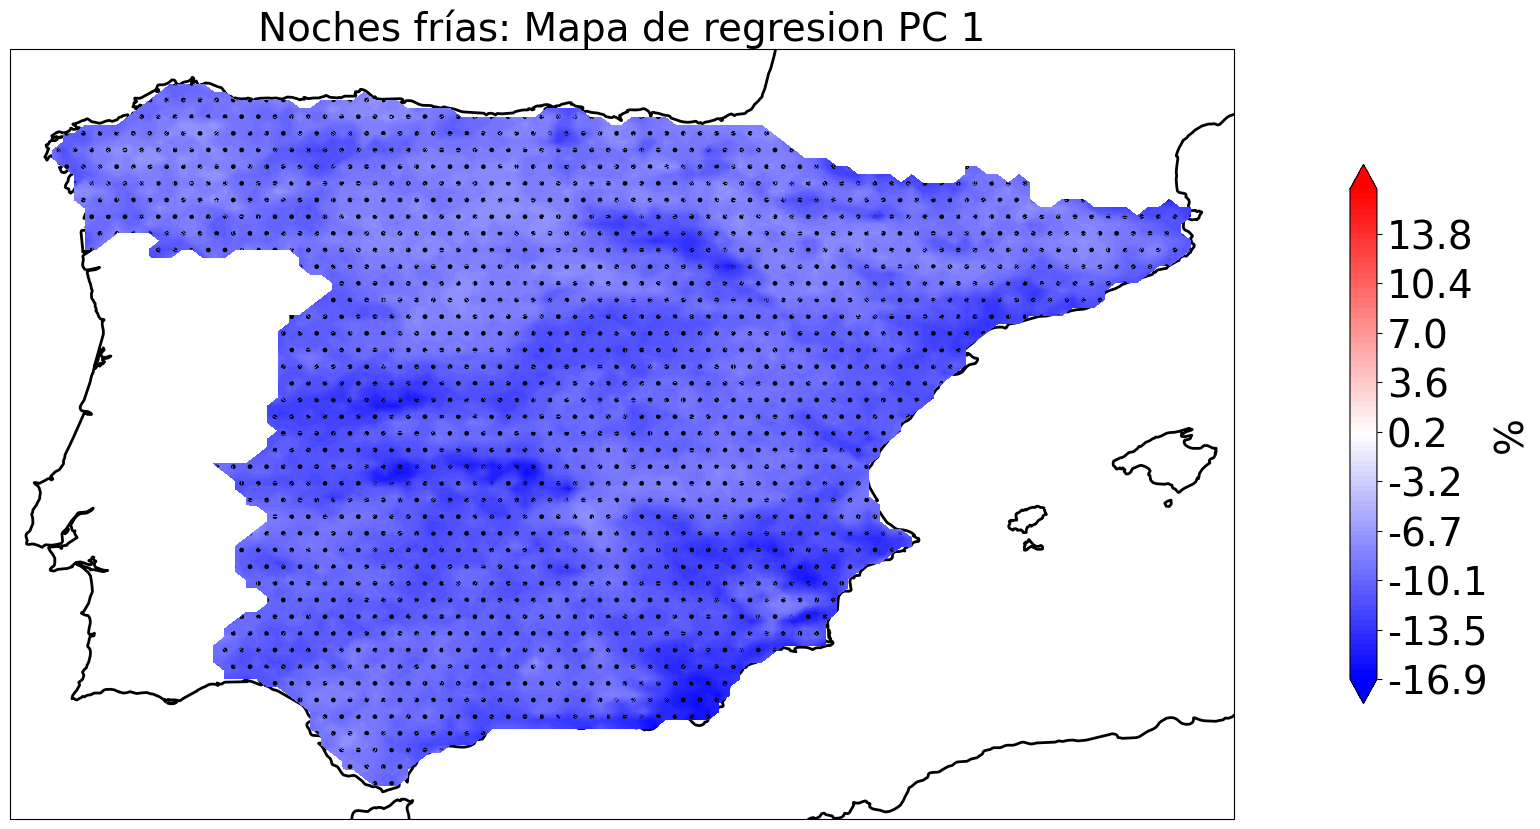

In [32]:
rango_reg=max(abs(np.nanmin(reg1_final)),abs(np.nanmax(reg1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1_final,(nlat,nlon)),lon,lat,levels,'bwr','%','Noches frías: Mapa de regresion PC 1', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_1_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

Cuando hace frío hace frío en toda españa a la vez. No hay dipolos en el mapa.

(-0.998903824452091, 9.004552246211179e-151)


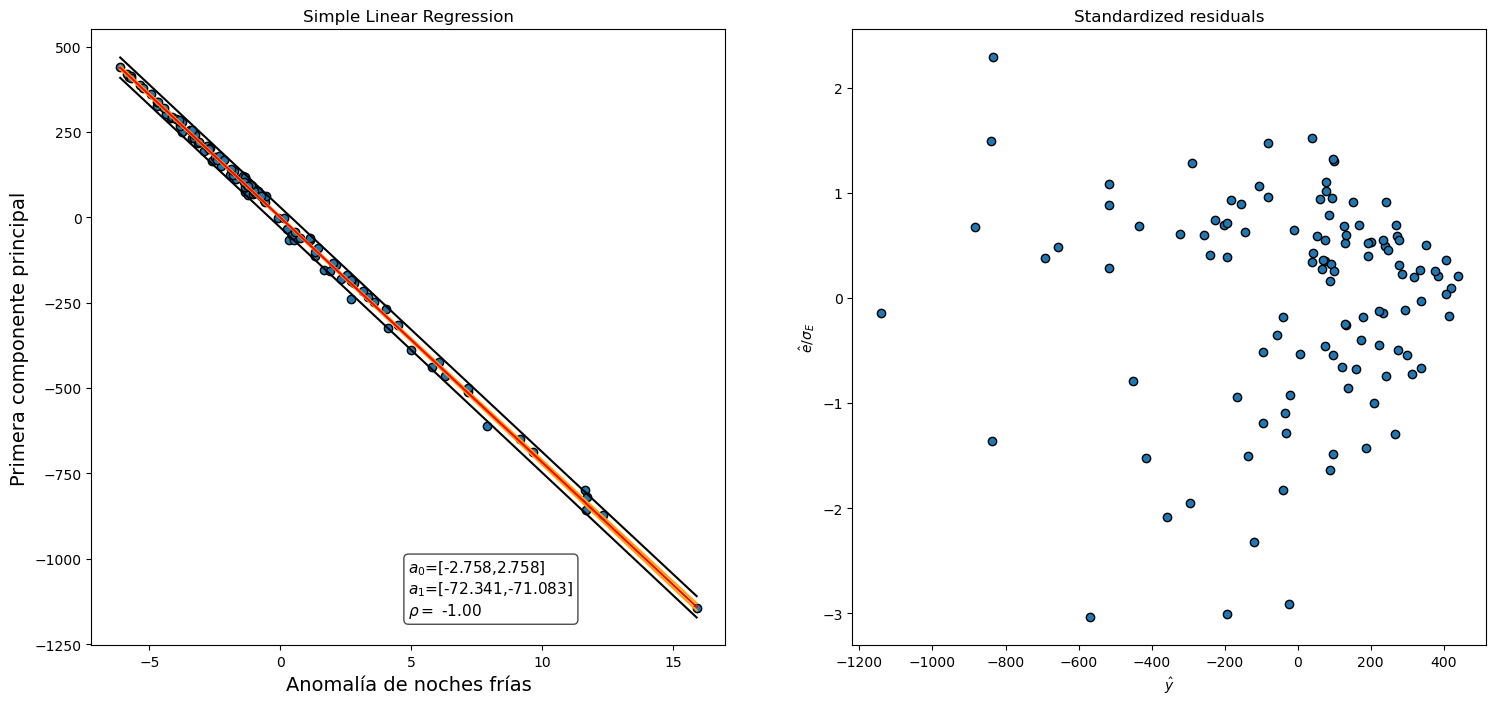

In [33]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(np.nanmean(tn10_primavera_anomalia,axis=(1,2)),PC_N[:,0])
ax[0].set_xlabel('Anomalía de noches frías',size=14)
ax[0].set_ylabel('Primera componente principal',size=14)
print(pearsonr(np.nanmean(tn10_primavera_anomalia,axis=(1,2)),PCs_N[:,0]))

Text(0.5, 1.0, 'Serie anomalías de noches frías (primavera)')

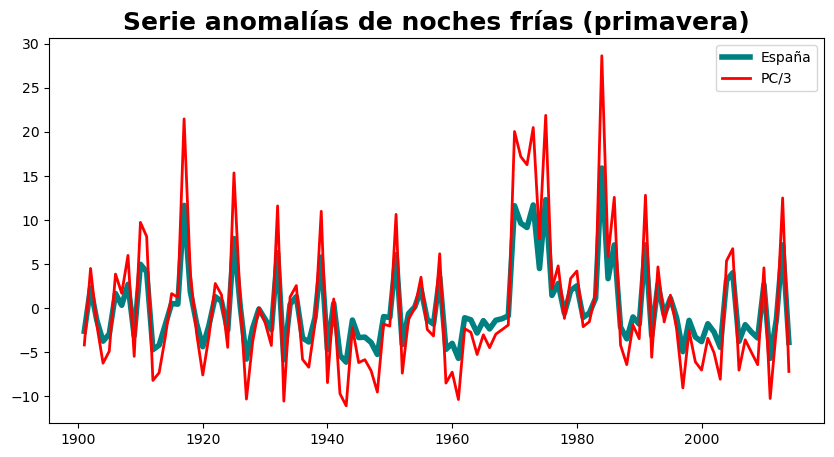

In [34]:

fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1901,2014+1),np.nanmean(tn10_primavera_anomalia,axis=(1,2)),linewidth= 4,color='teal',label='España')

var = np.nanmean(np.squeeze(reg1_final))

ax.plot(range(1901,2014+1),PCs_N[:,0]*var/3,linewidth= 2,color='r',label='PC/3')


ax.legend()
ax.set_title('Serie anomalías de noches frías (primavera)',fontsize=18,weight='bold')

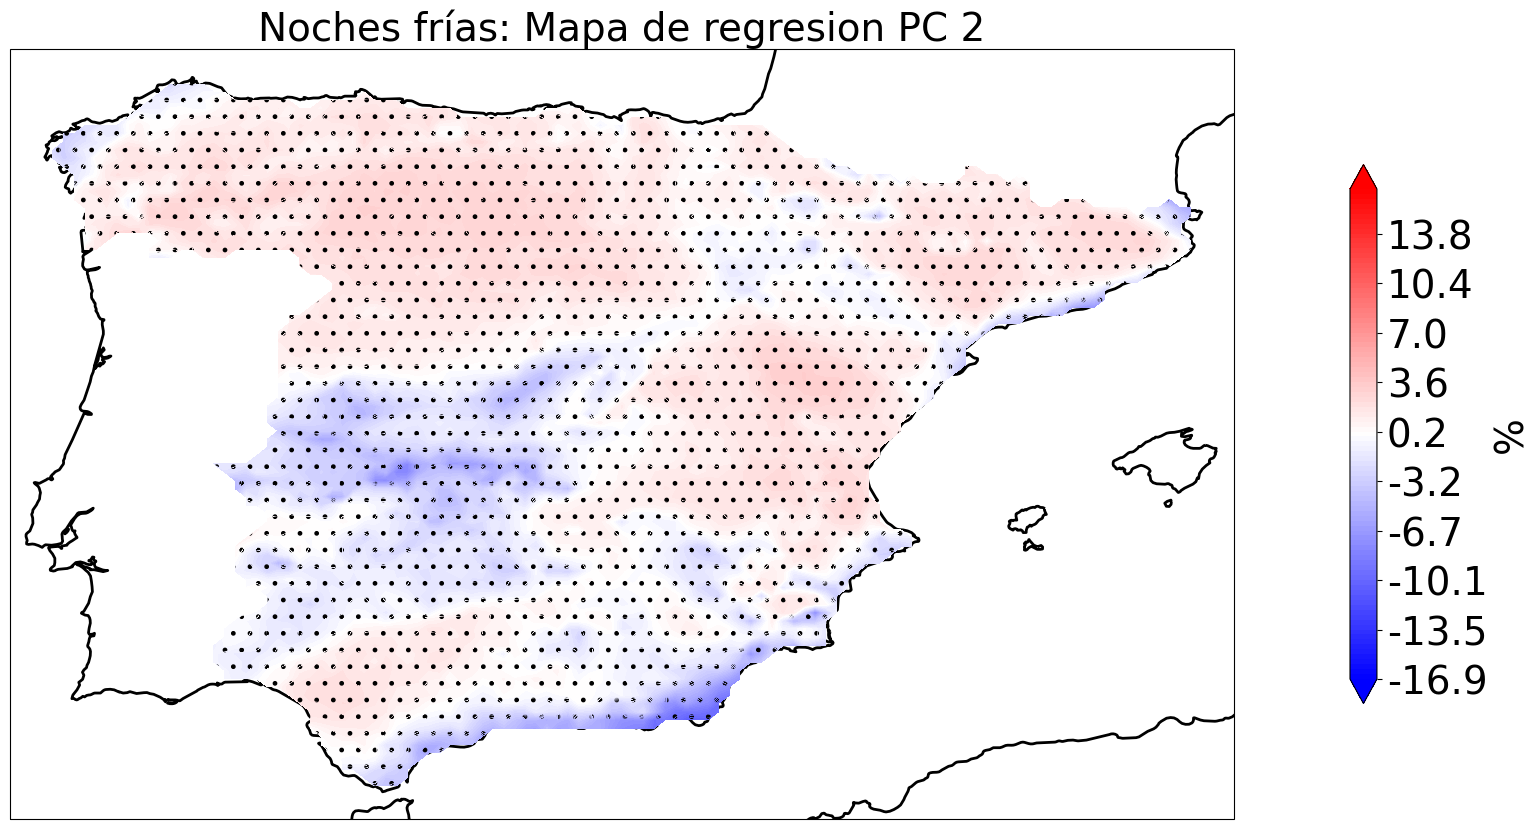

In [35]:
rango_reg=max(abs(np.nanmin(reg1_final)),abs(np.nanmax(reg1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg2_final,(nlat,nlon)),lon,lat,levels,'bwr','%','Noches frías: Mapa de regresion PC 2', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_2_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

En este mapa se ve un dipolo. Cuando hay color rojo en el norte, indica un aumento en porcentaje de días fríos, por lo tanto indica más fríos, mientras que el color azul indica una diminución de días fríos en zonas más al sur, es decir una disminución del frío.

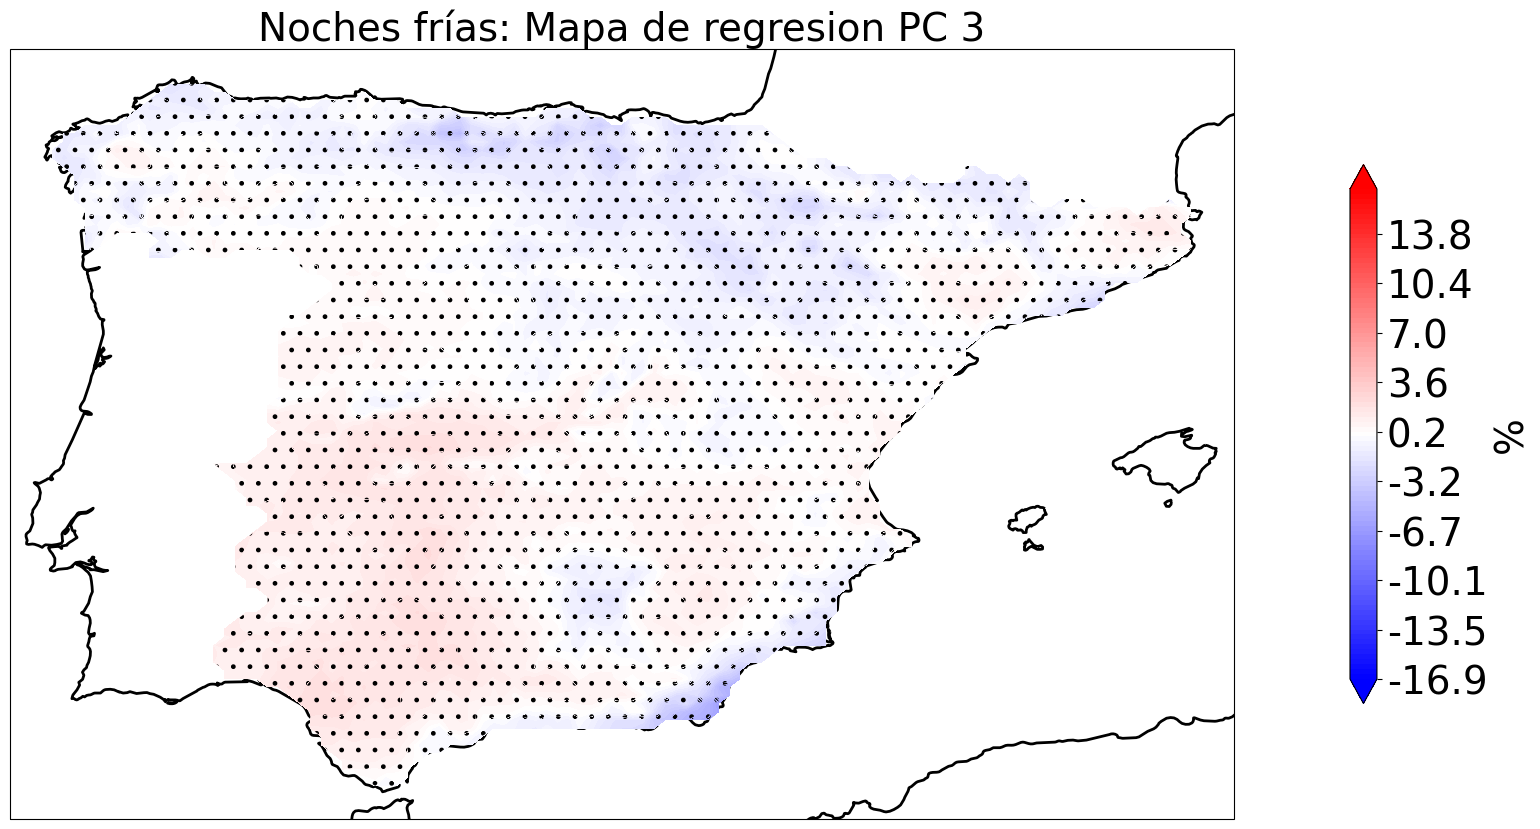

In [36]:
rango_reg=max(abs(np.nanmin(reg1_final)),abs(np.nanmax(reg1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg3_final,(nlat,nlon)),lon,lat,levels,'bwr','%','Noches frías: Mapa de regresion PC 3', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_3_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')

Este mapa nos dice que cuando hay un aumento de porcentaje de días fríos en el sur, hay una disminución de días fríos en zonas más al norte, aquí también se tiene una especie de dipolo.

In [37]:
picos_frios=np.where(PCs_N[:,0]<-4)[0]
pico_1917=picos_frios[0]
pico_1970=picos_frios[1]
pico_1973=picos_frios[2]
pico_1975=picos_frios[3]
pico_1984=picos_frios[4]
picos_frios

array([16, 24, 69, 70, 71, 72, 74, 83])

In [38]:
picos_calidos=np.where(PCs_N[:,0]>1.97)[0]
picos_calidos

array([ 11,  12,  19,  26,  32,  39,  41,  42,  46,  47,  51,  58,  59,
        60,  96,  99, 102, 105, 110, 113])

In [39]:
pico_1997=picos_calidos[-2]

# Reconstruimos años
En la primera componente principal, se veían varios picos negativos en los años 1917, 1970, 1973, 1975, 1984 y picos positivos en años como 1997. Vamos a centrarnos en el año 1997 y 1984.

Text(0.5, 1.0, 'Índice de noches frías primavera año: 1917')

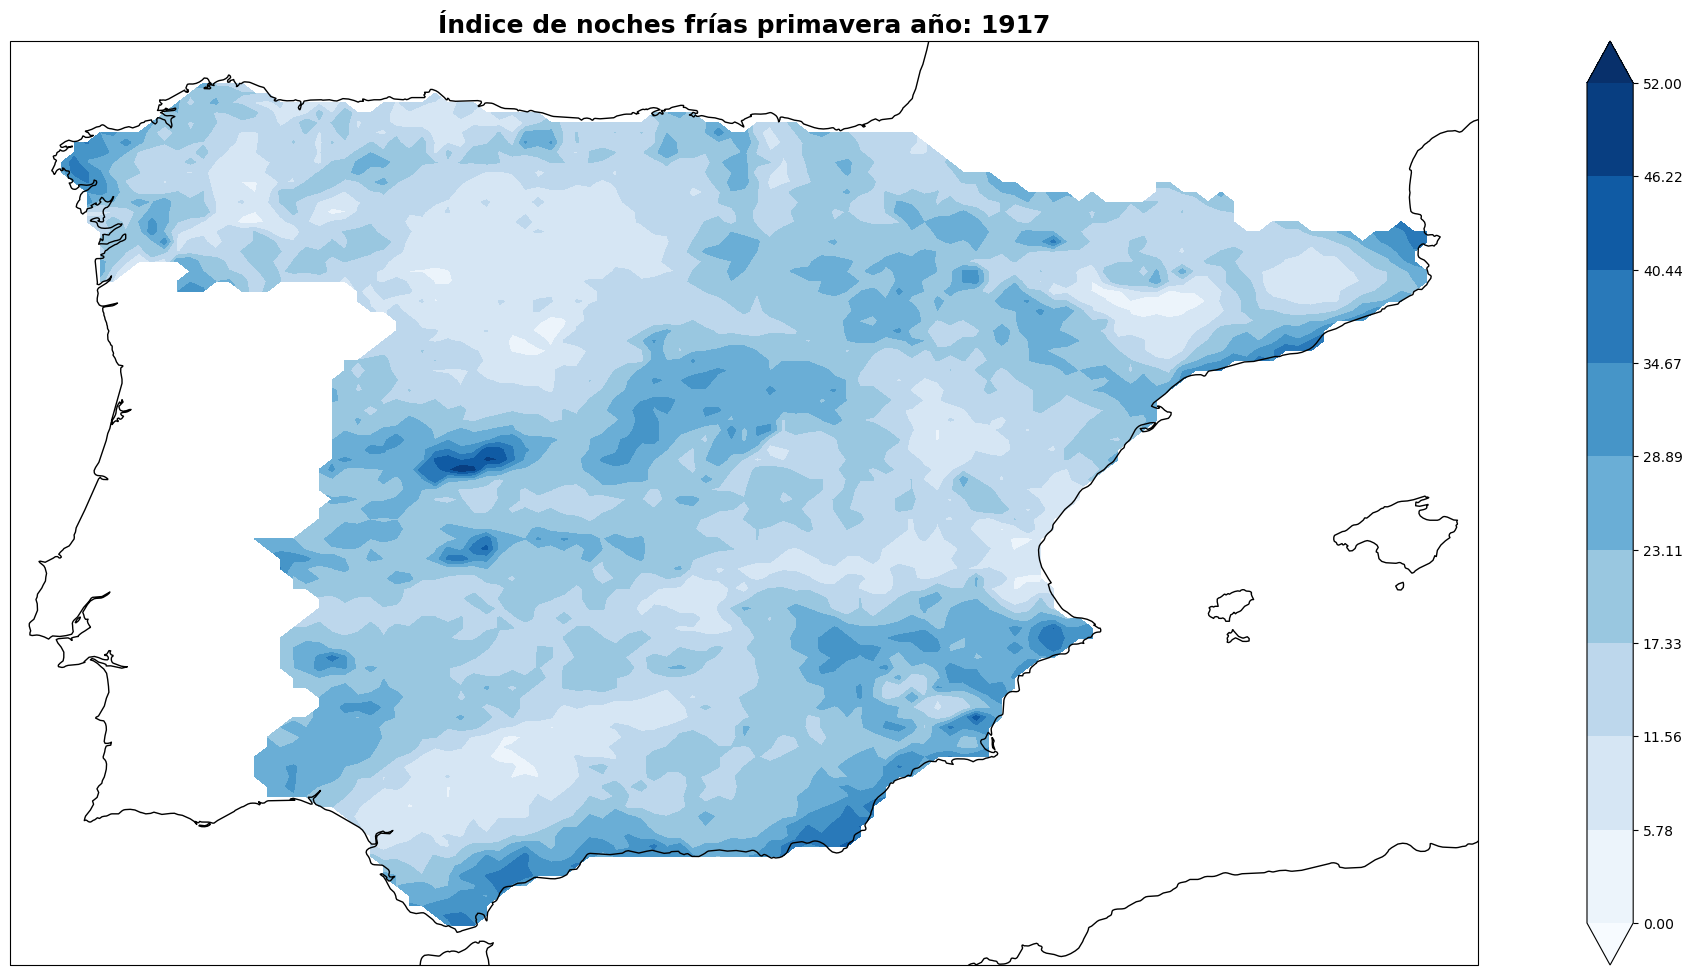

In [40]:
[nt,nlat,nlon]=tn10_primavera.shape
tn10_primavera_resh=np.reshape(np.array(tn10_primavera), (int(nt/3),3,nlat,nlon)).mean(axis=1)
tn10_primavera_resh.shape

fig = plt.figure(figsize=(28,12)) 
campo=tn10_primavera_resh[16,:,:]
levels=np.linspace(np.nanmin(campo),52,10)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,campo,cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree(),levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Índice de noches frías primavera año: '+str(1917),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Reconstrucción del índice con PC1, año: 1917')

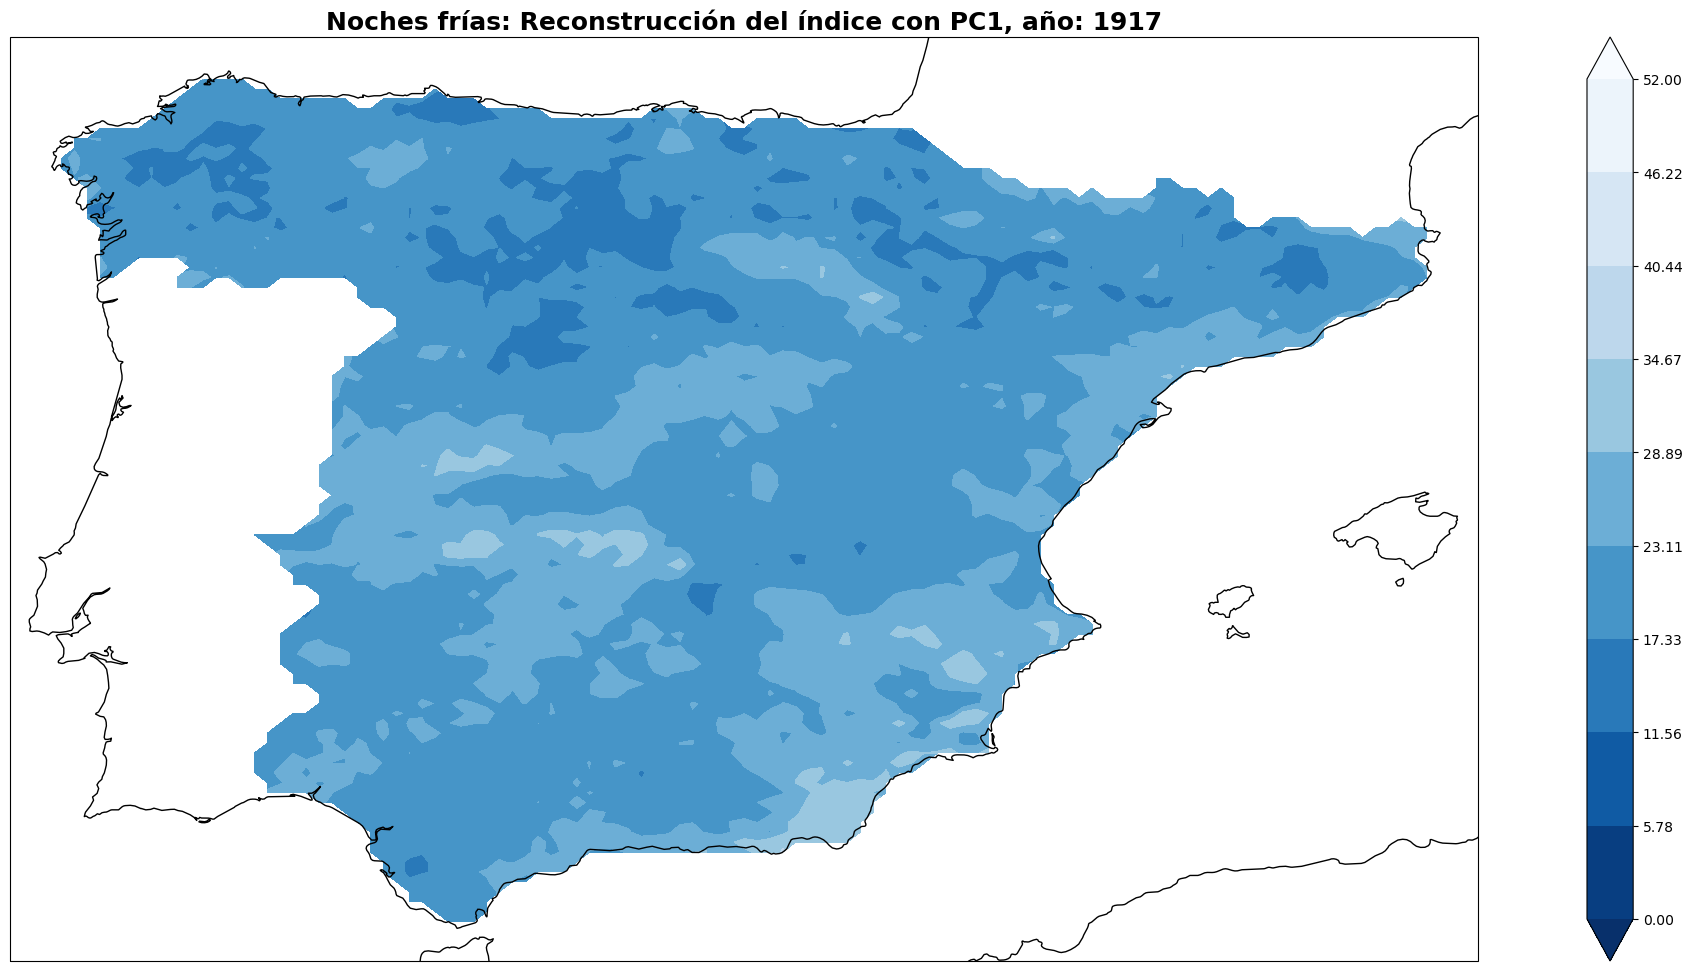

In [41]:
yrss=np.linspace(1901,2014,114)
year1916=1917
yr1916=reg1_final*PCs_N[yrss==year1916,0]/3

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,yr1916.reshape(len(lat),len(lon)),cmap='Blues_r',extend='both'
               ,transform = ccrs.PlateCarree(), levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Reconstrucción del índice con PC1, año: '+str(year1916),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Reconstrucción del índice con PC1+PC2+PC3, año: 1917')

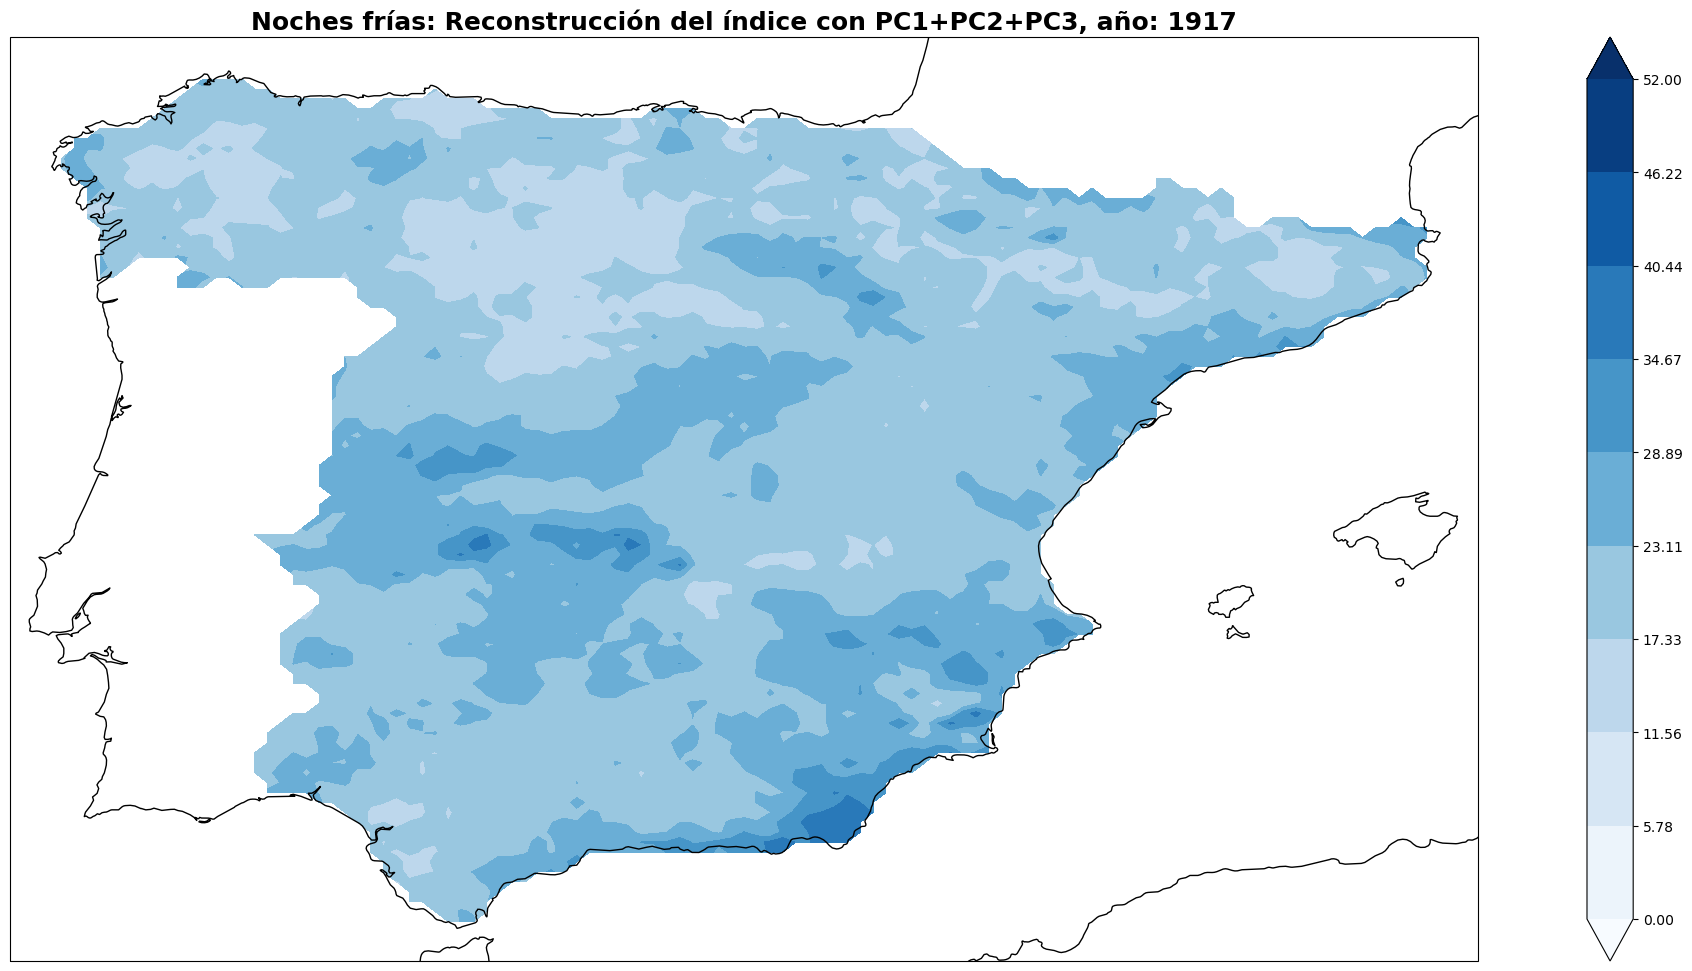

In [42]:

Yreconst_varios=reg1_final*PCs_N[yrss==year1916,0]/3+reg2_final*PCs_N[yrss==year1916,1]/3+reg3_final*PCs_N[yrss==year1916,2]/3
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Yreconst_varios.reshape(len(lat),len(lon)),cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree(), levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Reconstrucción del índice con PC1+PC2+PC3, año: '+str(year1916),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Índice de noches frías primavera año: 1984')

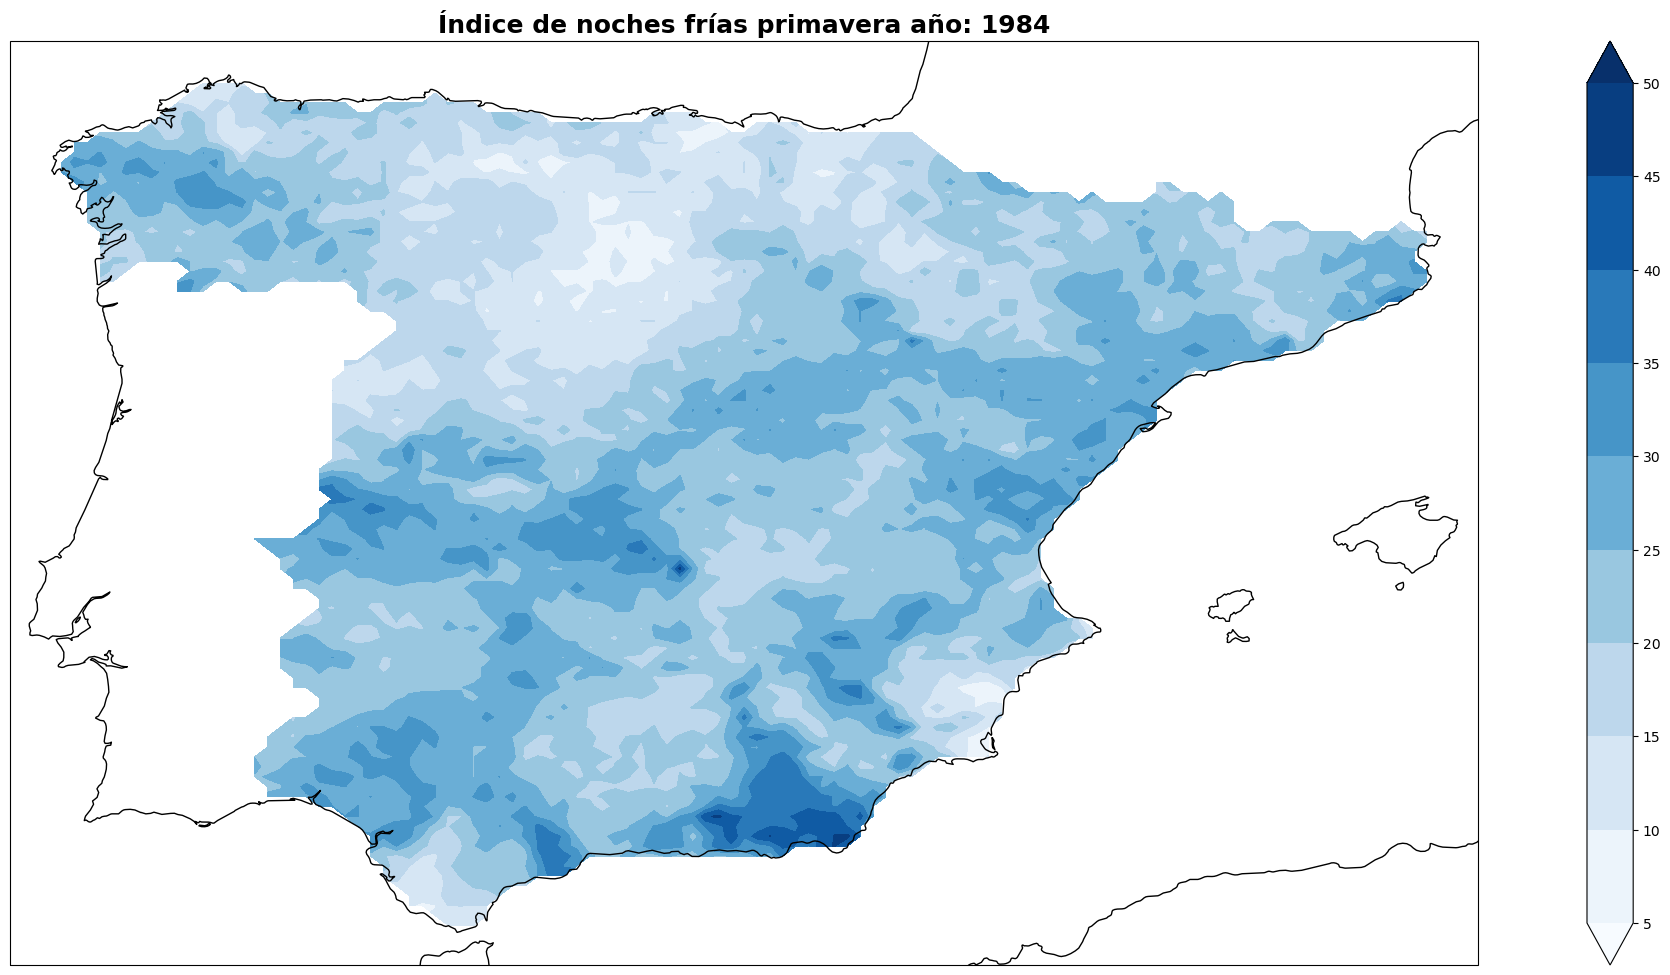

In [43]:
fig = plt.figure(figsize=(28,12)) 
campo=tn10_primavera_resh[83,:,:]
levels=np.linspace(5,50,10)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,campo,cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree(), levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Índice de noches frías primavera año: '+str(1984),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Reconstrucción del índice con PC1, año: 1984')

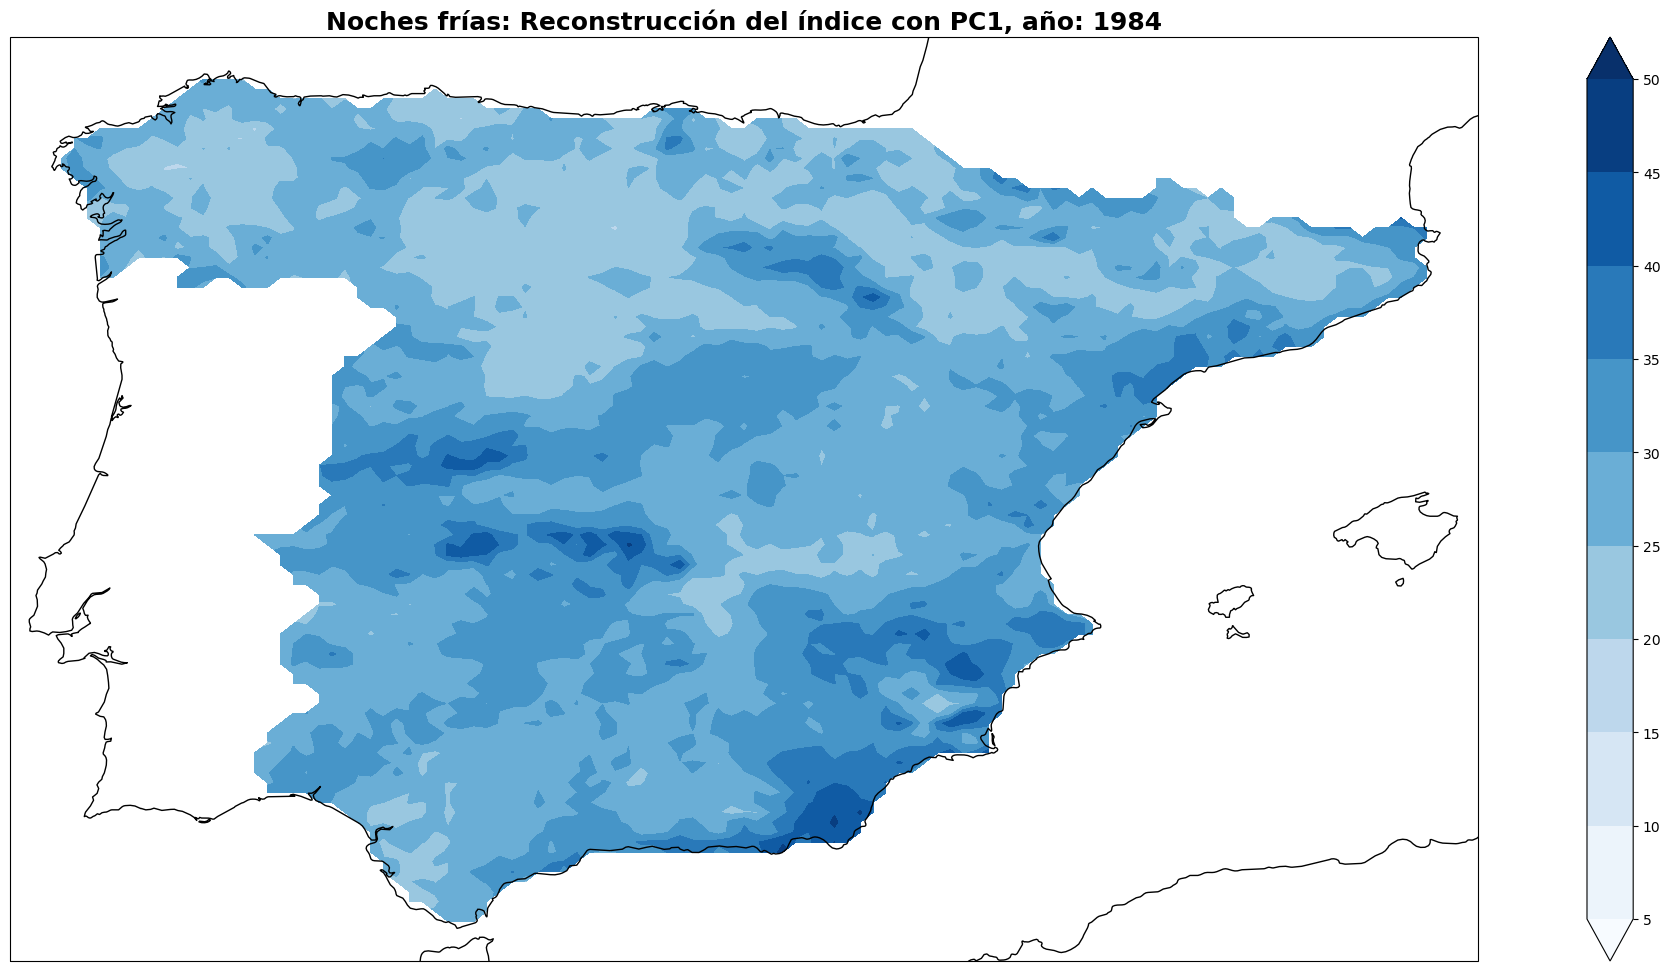

In [44]:
year1984=1984
Yreconst=reg1_final*PCs_N[yrss==year1984,0]/3
levels=np.linspace(5,50,10)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Yreconst.reshape(len(lat),len(lon)),cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree(), levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Reconstrucción del índice con PC1, año: '+str(year1984),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Reconstrucción del índice con PC1+Pc2+PC3, año: 1984')

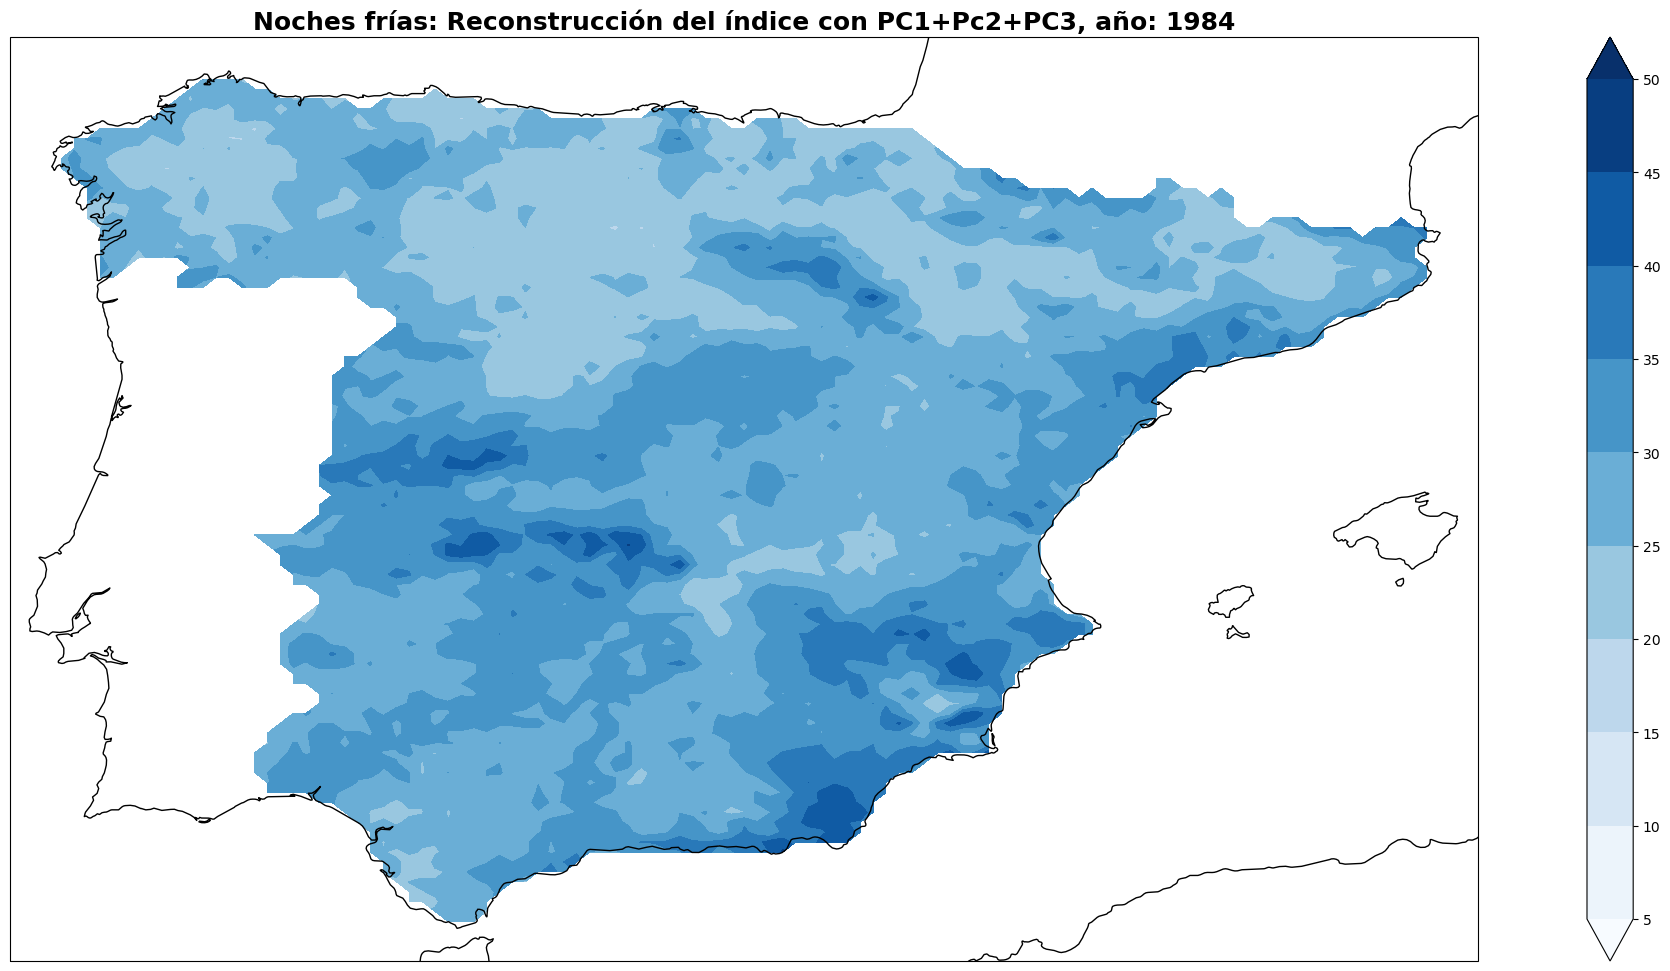

In [45]:
year1984=1984
Yreconst=reg1_final*PCs_N[yrss==year1984,0]/3+reg2_final*PCs_N[yrss==year1984,1]/3+reg3_final*PCs_N[yrss==year1984,2]/3
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Yreconst.reshape(len(lat),len(lon)),cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree(), levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Reconstrucción del índice con PC1+Pc2+PC3, año: '+str(year1984),fontsize=18,weight='bold')

## Anomalías de los años 1997 y 1984

Vamos a dibujar las anomalías de los años 1997 y 1984

Text(0.5, 1.0, 'Noches frías: Anomalía, año: 1997')

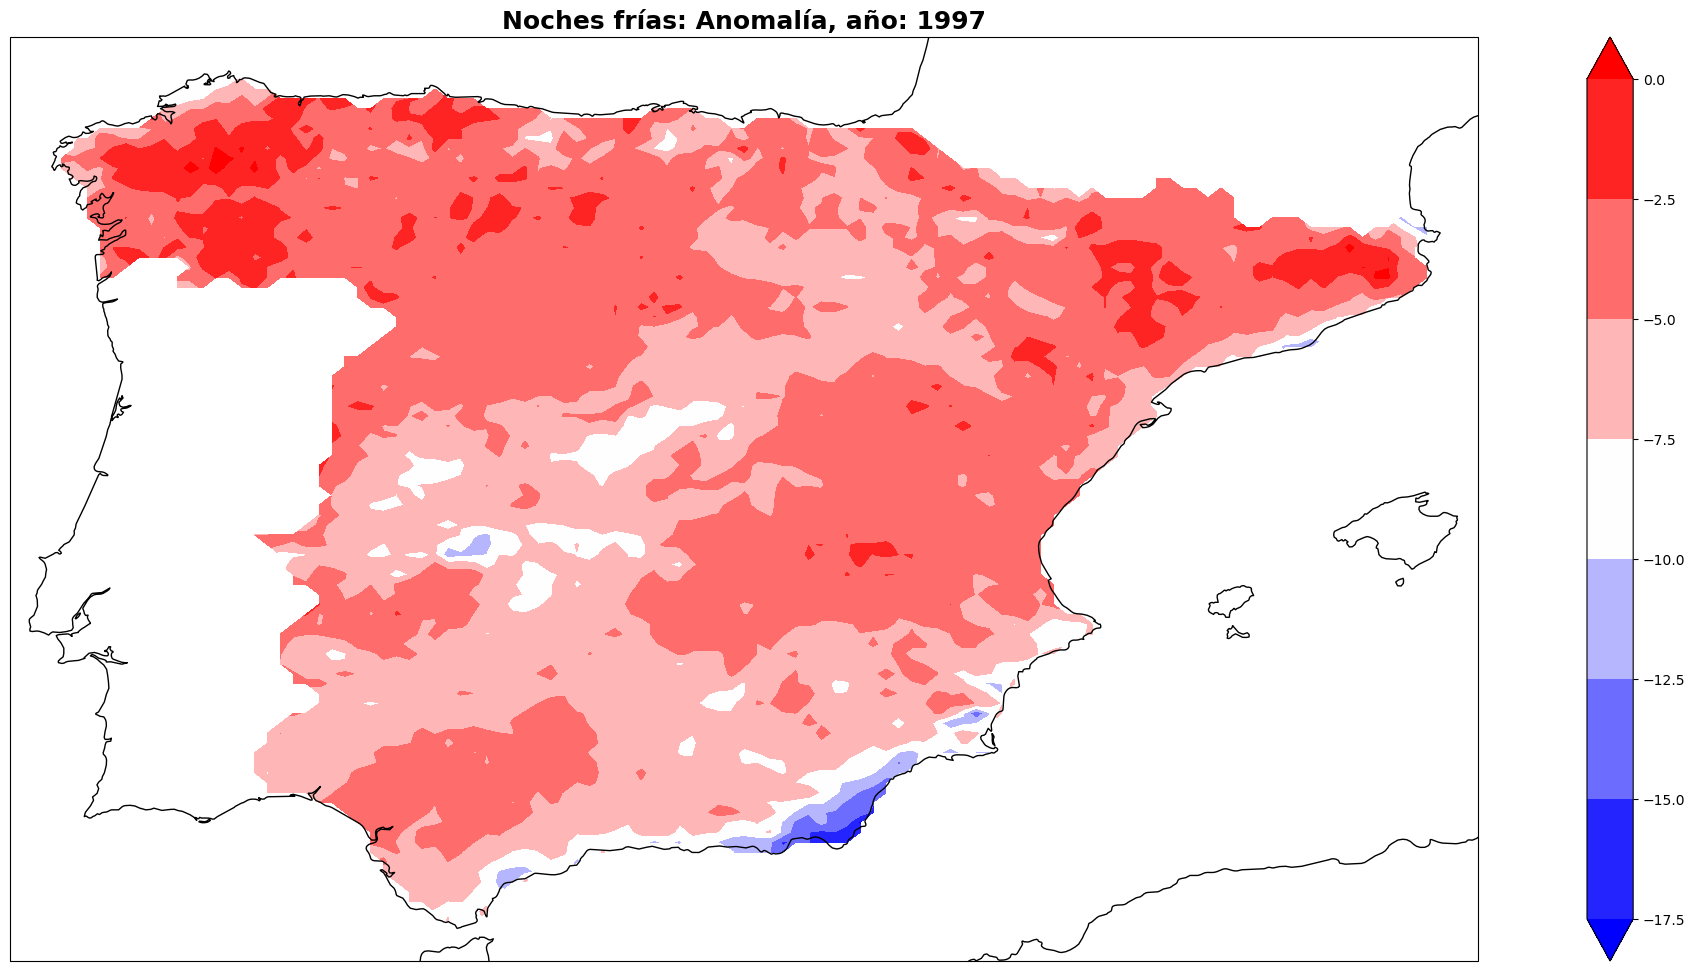

In [46]:
year1997=1997
yr1997=tn10_primavera_anomalia[yrss==year1997]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,yr1997.reshape(len(lat),len(lon)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Anomalía, año: '+str(year1997),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Anomalía, año: 1984')

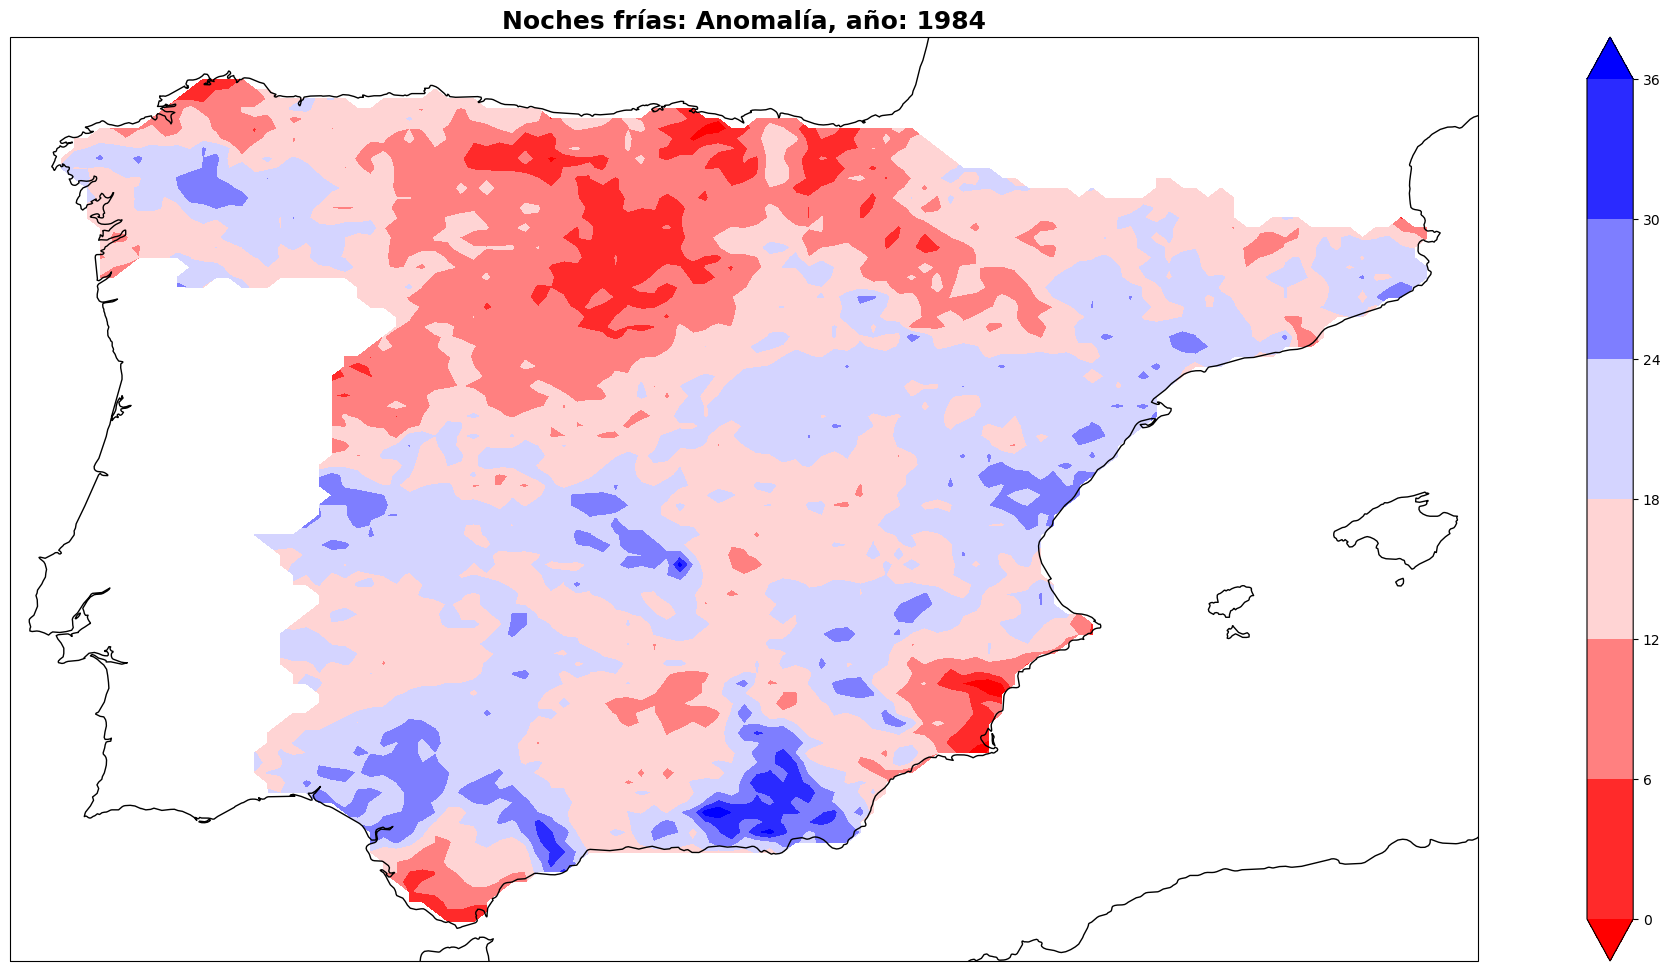

In [47]:
year1984=1984
yr1984=tn10_primavera_anomalia[yrss==year1984]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,yr1984.reshape(len(lat),len(lon)),cmap='bwr_r',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Anomalía, año: '+str(year1984),fontsize=18,weight='bold')

## Vamos a ver los mapas de SLP y SST para las dos primaveras reconstruidas anteriormente

In [48]:

path_slp= '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/ERA20/slp_ERA20_1900-2010.nc'
slp_file= xr.open_dataset(path_slp)
slp_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-01-20 17:20:20 GMT by grib_to_netcdf-2.0.2: grib_to_ne...

In [49]:
lon_slp = slp_file.longitude
lat_slp = slp_file.latitude
SLP = slp_file.msl
nm = 12
nyears = int(slp_file.time.shape[0]/nm)

In [50]:
yrs=np.linspace(1900,2010,111)

In [51]:
lat_AN, lon_AN, AN=region(SLP,lon_slp,lat_slp, 260, 360, 10, 75)
AN_spring=AN.groupby('time.season')['MAM']
AN_spring_ano=AN_spring-AN_spring.mean(axis=0)
[nt,nlat,nlon]=AN_spring_ano.shape
AN_spring_ano=np.reshape(np.array(AN_spring_ano), (int(nt/3),3,nlat,nlon)).mean(axis=1)
ATN_winter_ano=np.reshape(AN_spring_ano,(111,nlat*nlon))


Primero representamos las anomalías para la SLP en el atlánico en esos años

Text(0.5, 1.0, 'Noches frías: Anomalía SLP primavera 1984')

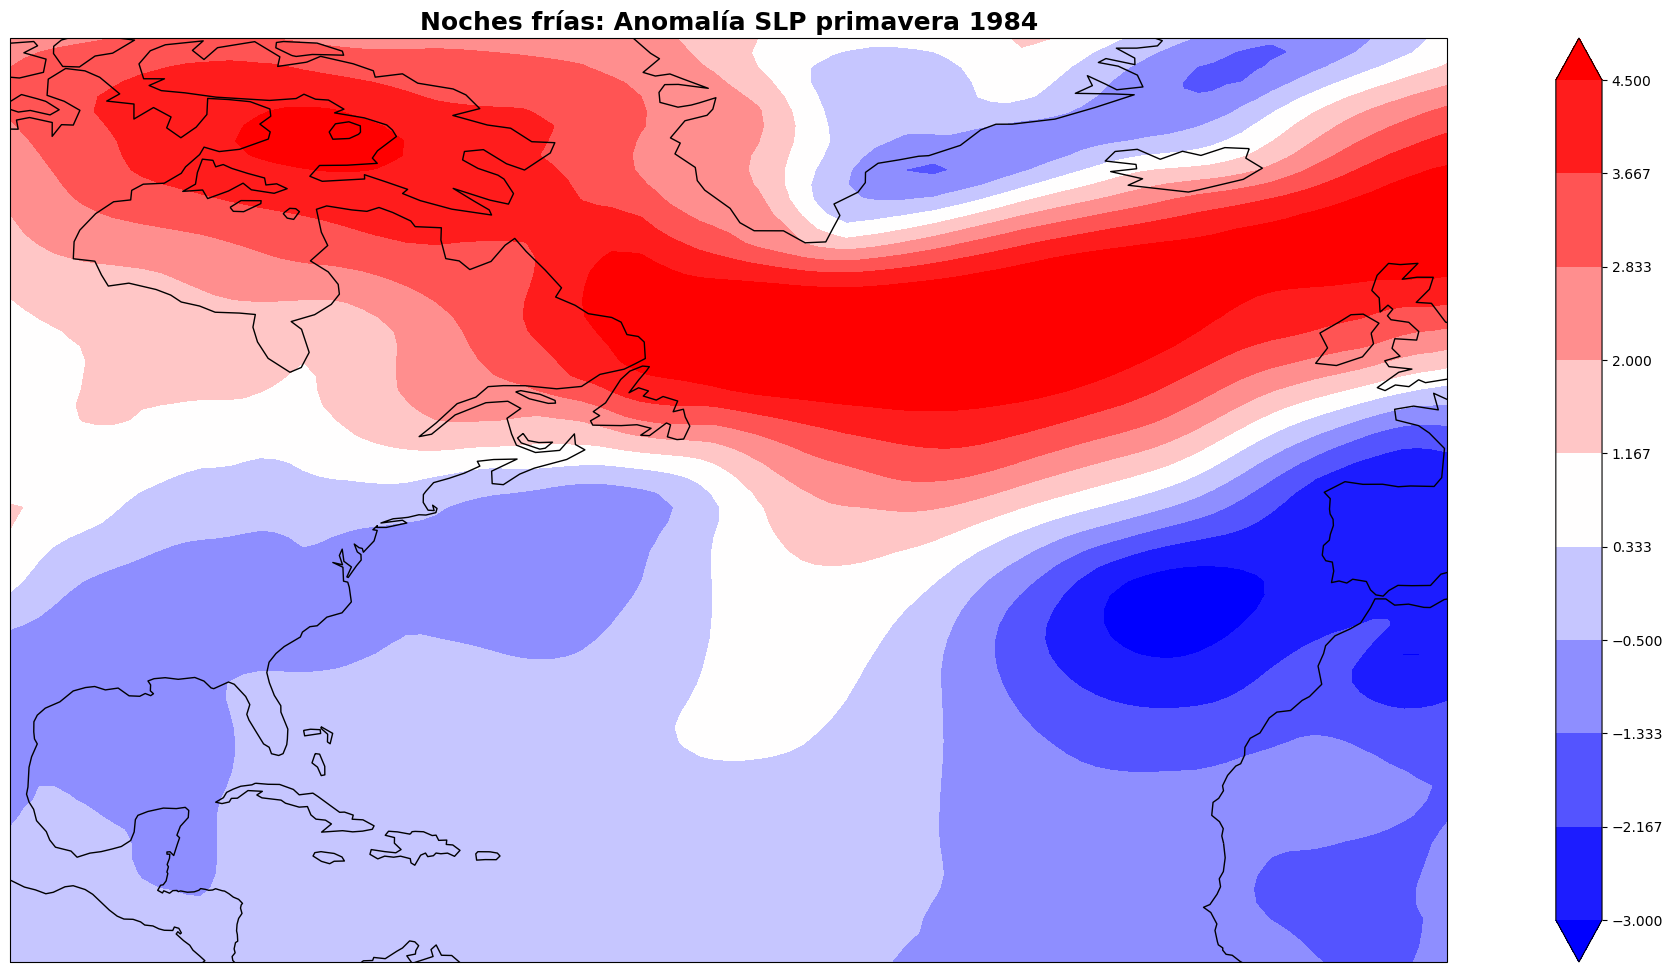

In [52]:
Y=ATN_winter_ano[yrs==year1984]
fig = plt.figure(figsize=(28,12)) 
levels=np.linspace(-3,4.5,10)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AN,lat_AN,Y.reshape(len(lat_AN),len(lon_AN))/100,cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree(),levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Anomalía SLP primavera '+str(year1984),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Noches frías: Anomalía SLP primavera 1997')

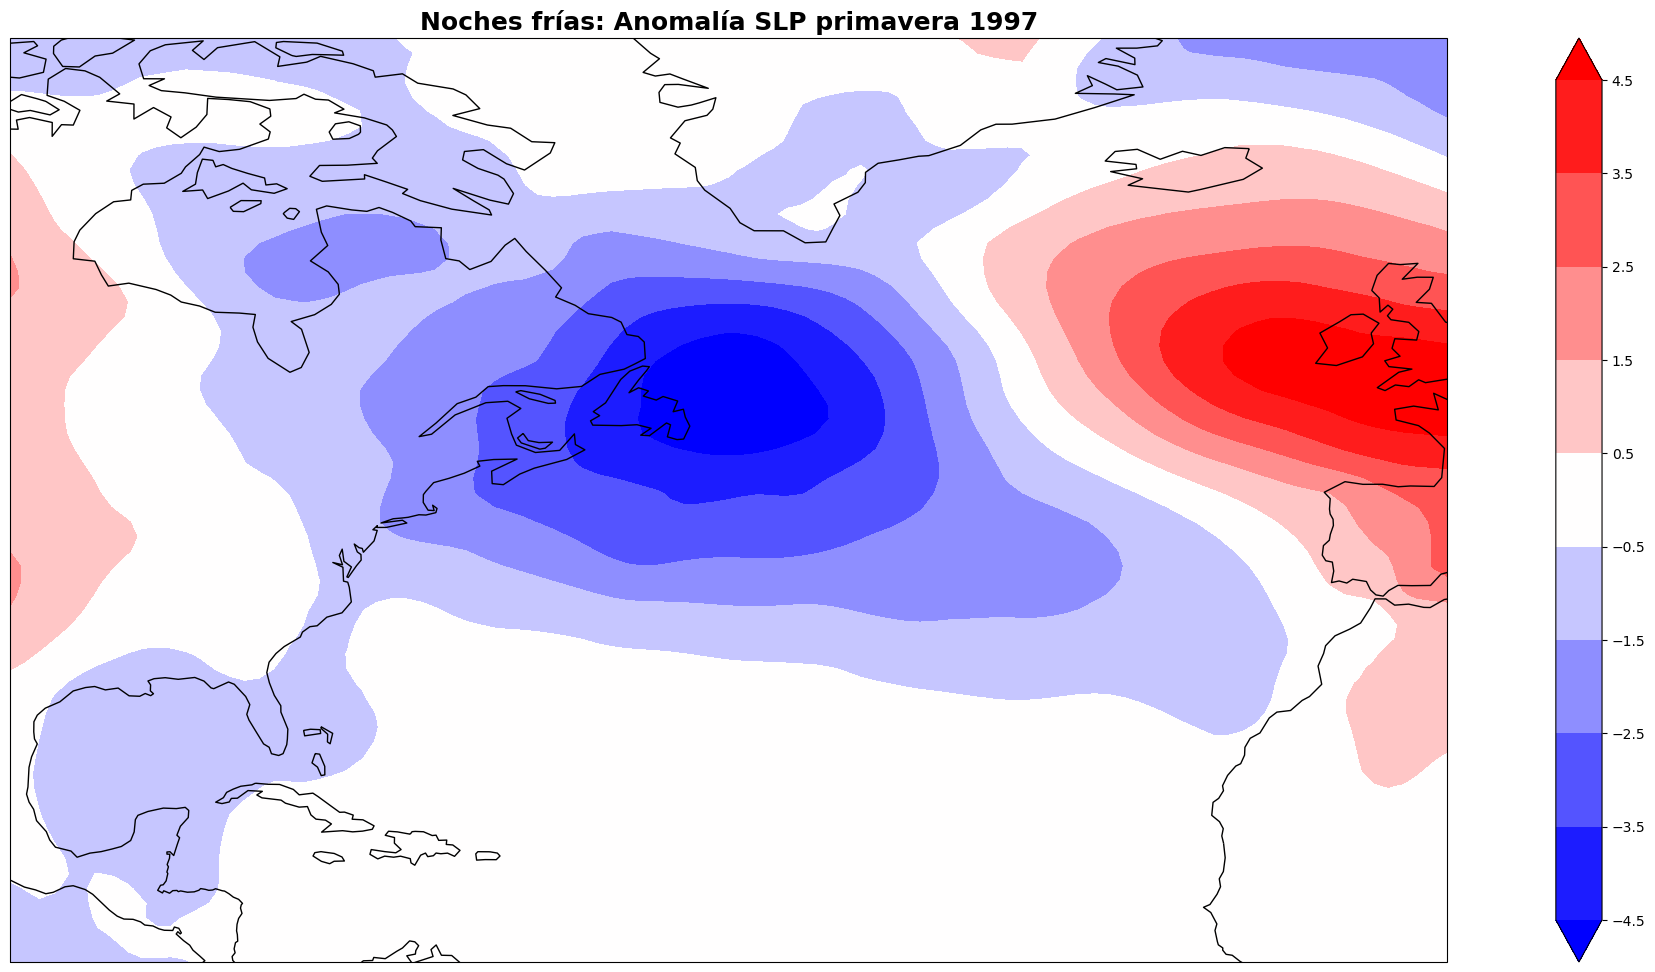

In [53]:
Y=ATN_winter_ano[yrs==year1997]
fig = plt.figure(figsize=(28,12)) 
levels=np.linspace(-4.5,4.5,10)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AN,lat_AN,Y.reshape(len(lat_AN),len(lon_AN))/100,cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree(),levels=levels)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Noches frías: Anomalía SLP primavera '+str(year1997),fontsize=18,weight='bold')

Ahora representaremos la sst para el invierno y primavera de esos años

In [54]:
#Cargo los datos SST:
path_sst= '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/HadISST1/HadISST1_sst_1870-2019.nc'
sst_file= xr.open_dataset(path_sst)
lon_sst = sst_file.longitude
lat_sst = sst_file.latitude
sst = sst_file.sst
nt, nlat, nlon = sst.shape
nm = 12
nyearssst = int(nt/nm)

lonmin,lonmax,latmin,latmax = -270, -70, -20, 20

SST,lat_sst,lon_sst=region2(sst,lat_sst,lon_sst,lonmin,lonmax,latmin,latmax)
yrsst=np.linspace(1870,2019,150)
SST=SST[:150*12,:,:]
SST=np.array(SST)
SST=np.reshape(SST, (150,12,len(lat_sst),len(lon_sst)))

In [55]:
# reorganizo los datos para que estén en numero de años, numero de meses y espacio
SST=np.reshape(SST, (len(yrsst),12,len(lon_sst)*len(lat_sst)))
#ahora calculo las medias estacionales, por ejemplo del mes 9 (octubre) al mes 1 (febrero)
# es decir tengo una estación extendida
SST_sea,ny1=season(SST,9,1,111)

SST_sea2,ny12=season(SST,2,4,111)

In [56]:
# Ahora voy a calcular las anomalias
#anomalías positivas en la SST nos van a indicar un evento de el niño

SST_sea_an=anom(np.transpose(SST_sea),1,'pp')

SST_sea_an2=anom(np.transpose(SST_sea2),1,'pp')


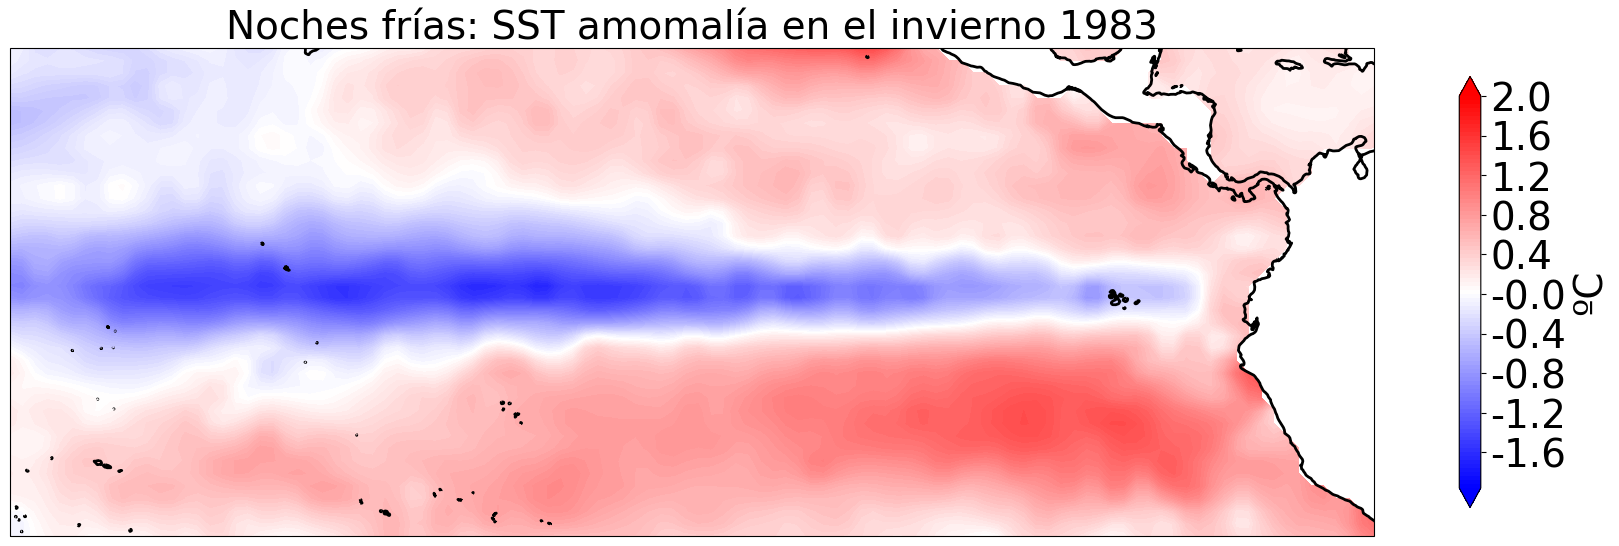

In [57]:
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(SST_sea_an[:,np.where(yrsst==year1984-1)],(len(lat_sst),len(lon_sst))),lon_sst,lat_sst,np.linspace(-2,2,100), 'bwr', 'ºC','Noches frías: SST amomalía en el invierno '+str(year1984-1),ax)


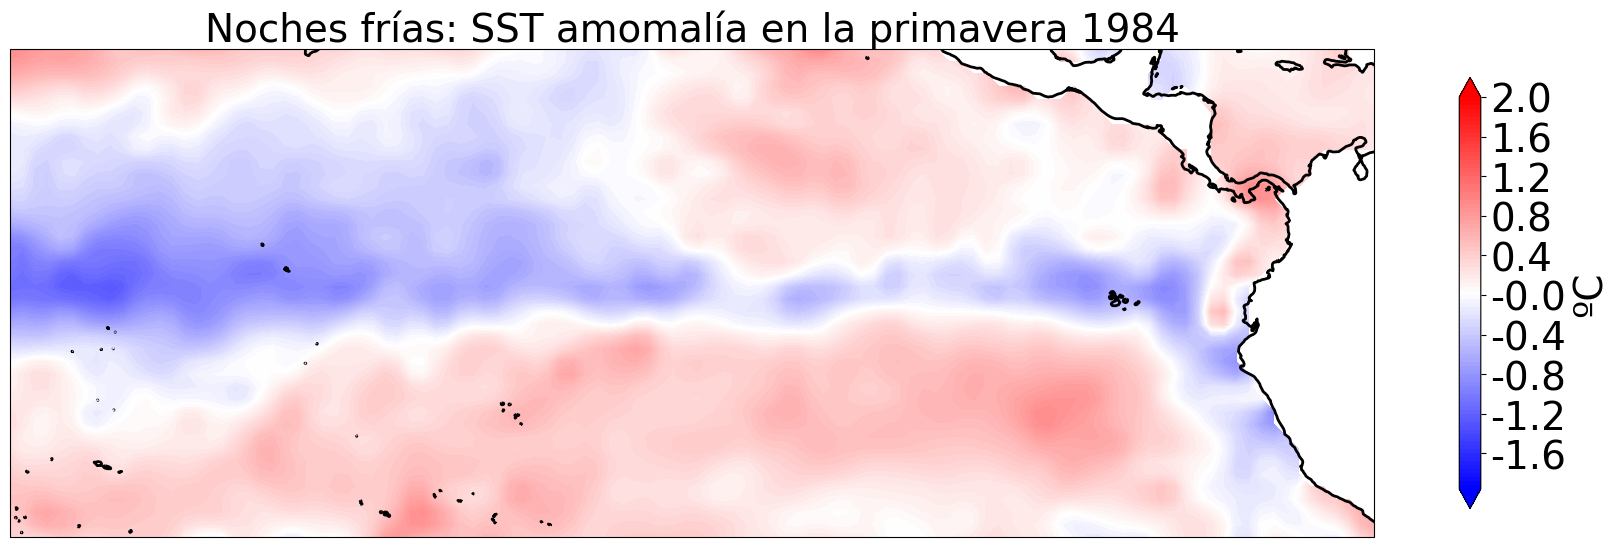

In [58]:
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(SST_sea_an2[:,np.where(yrsst==year1984)],(len(lat_sst),len(lon_sst))),lon_sst,lat_sst,np.linspace(-2,2,100), 'bwr', 'ºC','Noches frías: SST amomalía en la primavera '+str(year1984),ax)


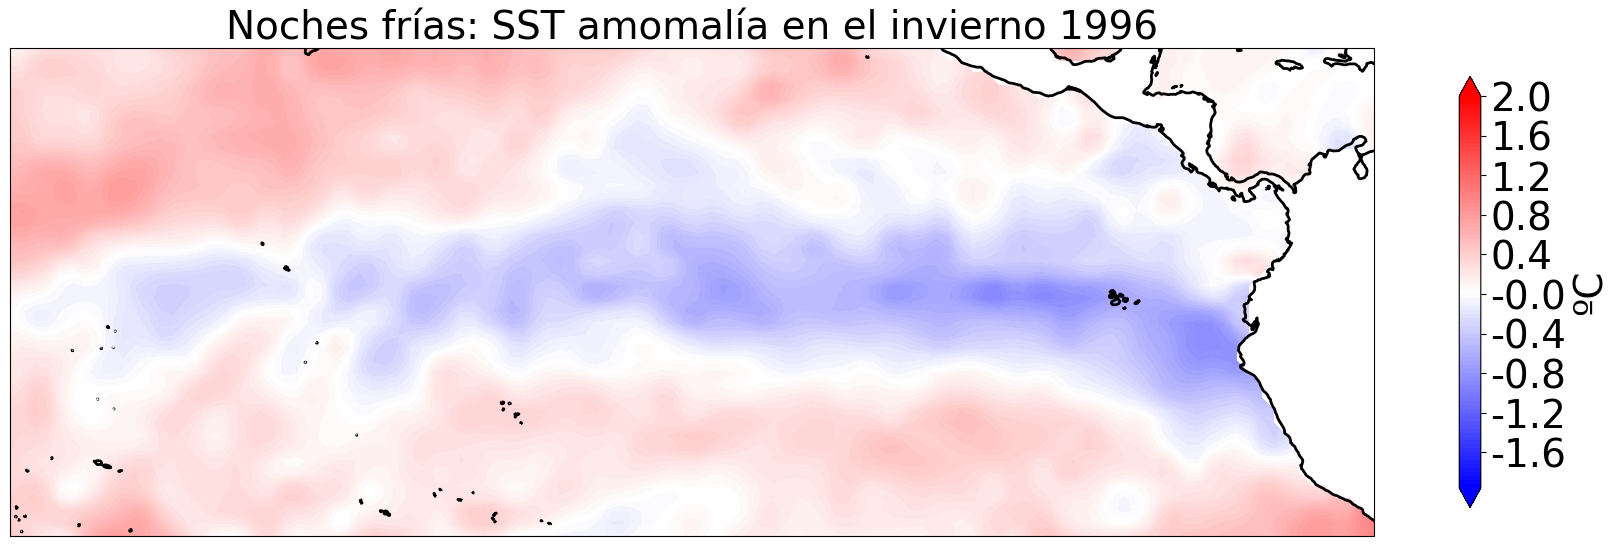

In [59]:
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(SST_sea_an[:,np.where(yrsst==year1997-1)],(len(lat_sst),len(lon_sst))),lon_sst,lat_sst,np.linspace(-2,2,100), 'bwr', 'ºC','Noches frías: SST amomalía en el invierno '+str(year1997-1),ax)


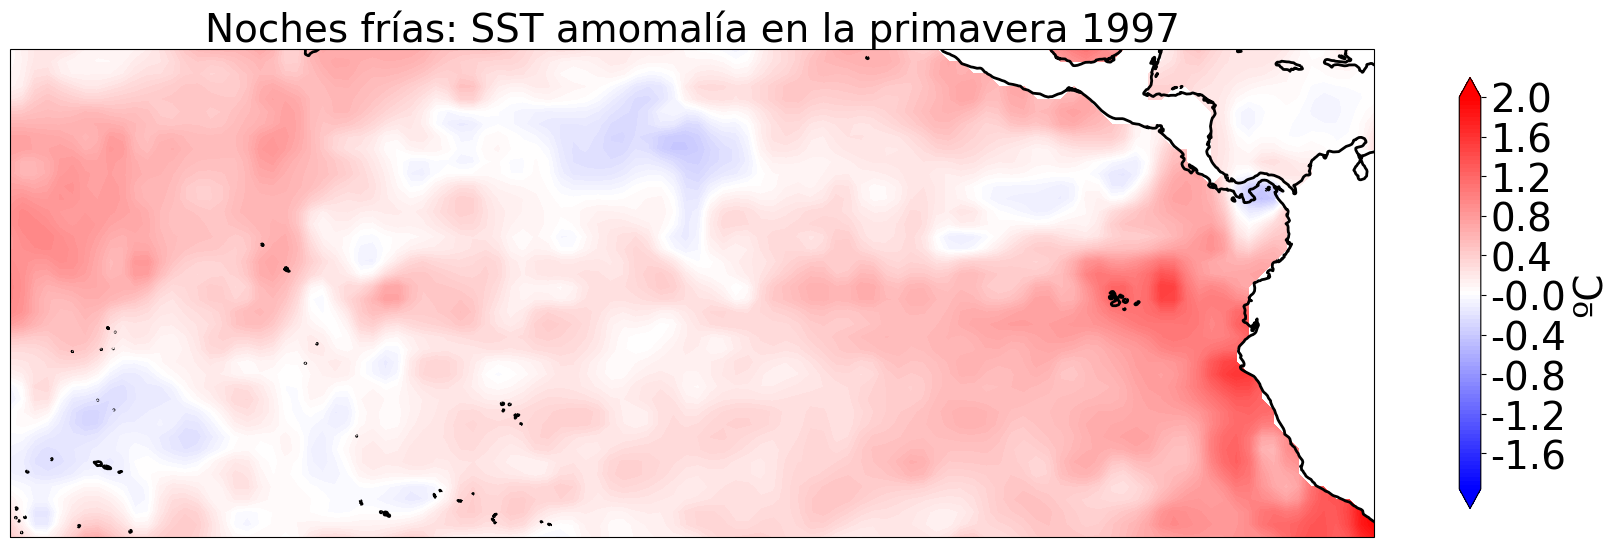

In [60]:
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(SST_sea_an2[:,np.where(yrsst==year1997)],(len(lat_sst),len(lon_sst))),lon_sst,lat_sst,np.linspace(-2,2,100), 'bwr', 'ºC','Noches frías: SST amomalía en la primavera '+str(year1997),ax)


### ¿Cómo se relacionan las EOFs con los índices de las diferntes regiones y con los índices de El Niño, la NAO, y las PCS de la SST y la SLP?

In [61]:

path_slp= '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/ERA20/slp_ERA20_1900-2010.nc'
slp_file= xr.open_dataset(path_slp)
slp_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-01-20 17:20:20 GMT by grib_to_netcdf-2.0.2: grib_to_ne...

In [62]:
# Vamos a tomar los puntos en Azores y en Islandia
Azores= [35, 335] #Ponta Delgada (São Miguel)
Islandia= [64.136319, 360-21.948231] #Reyjavick (o como se escriba)
escala= 1/100 #para tener la presión en hPa
Azores_point= slp_file.msl.sel(latitude=Azores[0],longitude=Azores[1],method='nearest')*escala
Islandia_point= slp_file.msl.sel(latitude=Islandia[0],longitude=Islandia[1],method='nearest')*escala
tiempo= slp_file.time

In [63]:
#ahora tomamos la anomalía estandarizada de presión entre estas dos estaciones
diferencia_presion= Azores_point-Islandia_point
#NAO= (diferencia_presion- diferencia_presion.mean())/diferencia_presion.std()
#hacemos la media y std por meses
NAO=((diferencia_presion.groupby('time.month')-diferencia_presion.groupby('time.month').mean('time'))).groupby('time.month')/diferencia_presion.groupby('time.month').std('time')
NAO

<xarray.DataArray 'msl' (time: 1332)>
array([ 0.74976099, -1.09638641, -1.86762482, ..., -0.22634874,
       -1.13392175, -2.87750959])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [64]:
TIEMPO = tiempo.indexes['time'].normalize()
TIEMPO

DatetimeIndex(['1900-01-01', '1900-02-01', '1900-03-01', '1900-04-01',
               '1900-05-01', '1900-06-01', '1900-07-01', '1900-08-01',
               '1900-09-01', '1900-10-01',
               ...
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
               '2010-11-01', '2010-12-01'],
              dtype='datetime64[ns]', name='time', length=1332, freq='MS')

<BarContainer object of 1332 artists>

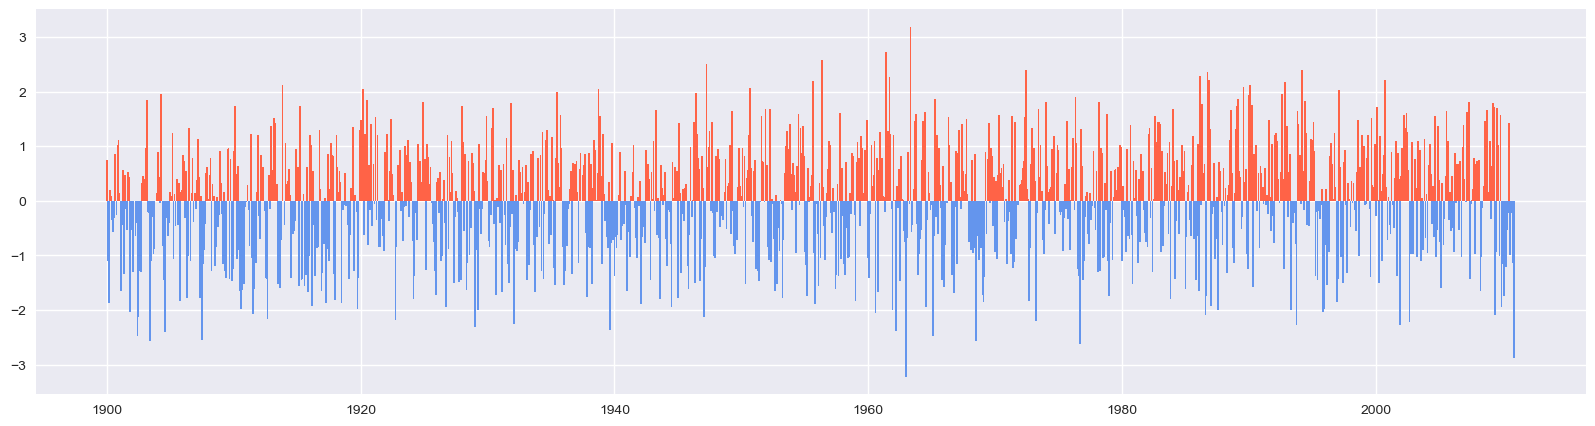

In [65]:
plt.style.use('seaborn')
fig, ax= plt.subplots(figsize=(20,5))
ax.bar(tiempo.indexes['time'].normalize(),NAO,width=50,color=np.where(NAO>0,'tomato','cornflowerblue'))

In [66]:
path_sst= '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/DATOS/HadISST1/HadISST1_sst_1870-2019.nc'
sst_file= xr.open_dataset(path_sst)
sst_file

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [67]:
lon_nino= [-150,-90]
lat_nino= [5,-5]


nino_3_region= sst_file.sel(latitude=slice(lat_nino[0],lat_nino[1]),longitude=slice(lon_nino[0],lon_nino[1]))
#calculamos la media espacial de SST para cada tiempo y calculamos la anomalía
nino_3= nino_3_region.sst.mean(axis=(1,2))
nino_3_region

<xarray.Dataset>
Dimensions:    (longitude: 60, latitude: 10, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -149.5 -148.5 -147.5 ... -92.5 -91.5 -90.5
  * latitude   (latitude) float32 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 26.08 26.04 ... 23.08 23.12
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [68]:
ANOMALIA_nino_3= ((nino_3.groupby('time.month')-nino_3.groupby('time.month').mean('time'))).groupby('time.month')/nino_3.groupby('time.month').std('time')
ANOMALIA_nino_3

<xarray.DataArray 'sst' (time: 1800)>
array([-1.31801861, -1.37176839, -0.87842486, ...,  0.23864259,
        0.56651978,  0.34075136])
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [69]:
invierno_nino= ANOMALIA_nino_3.groupby('time.season')['DJF']
primavera_nino= ANOMALIA_nino_3.groupby('time.season')['MAM']
verano_nino= ANOMALIA_nino_3.groupby('time.season')['JJA']
otono_nino= ANOMALIA_nino_3.groupby('time.season')['SON']

invierno_NAO= NAO.groupby('time.season')['DJF']
primavera_NAO= NAO.groupby('time.season')['MAM']
verano_NAO= NAO.groupby('time.season')['JJA']
otono_NAO= NAO.groupby('time.season')['SON']

In [70]:
#Reducimos los datos para la comparación entre los dos índices a entre 1985-2000
invierno_NAO_red= invierno_NAO[(invierno_NAO.time.dt.year<=2000)&(invierno_NAO.time.dt.year>=1985)]
primavera_NAO_red= primavera_NAO[(primavera_NAO.time.dt.year<=2000)&(primavera_NAO.time.dt.year>=1985)]
verano_NAO_red= verano_NAO[(verano_NAO.time.dt.year<=2000)&(verano_NAO.time.dt.year>=1985)]
otono_NAO_red= otono_NAO[(otono_NAO.time.dt.year<=2000)&(otono_NAO.time.dt.year>=1985)]

invierno_nino_red= invierno_nino[(invierno_nino.time.dt.year<=2000)&(invierno_nino.time.dt.year>=1985)]
primavera_nino_red= primavera_nino[(primavera_nino.time.dt.year<=2000)&(primavera_nino.time.dt.year>=1985)]
verano_nino_red= verano_nino[(verano_nino.time.dt.year<=2000)&(verano_nino.time.dt.year>=1985)]
otono_nino_red= otono_nino[(otono_nino.time.dt.year<=2000)&(otono_nino.time.dt.year>=1985)]

In [71]:
primavera_NAO.time

<xarray.DataArray 'time' (time: 333)>
array(['1900-03-01T00:00:00.000000000', '1900-04-01T00:00:00.000000000',
       '1900-05-01T00:00:00.000000000', ..., '2010-03-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-03-01 1900-04-01 ... 2010-05-01
    month    (time) int64 3 4 5 3 4 5 3 4 5 3 4 5 3 ... 3 4 5 3 4 5 3 4 5 3 4 5
Attributes:
    long_name:  time

In [72]:
#veamos si mi indice DE EL NIÑO EN PRIMAVERA se parece a la eof
primavera_nino_red= primavera_nino[(primavera_nino.time.dt.year<=2000)&(primavera_nino.time.dt.year>=1985)]
primavera_nino_red_reshape=np.reshape(np.asarray(primavera_nino_red),(int(primavera_nino_red.shape[0]/3),3)).mean(axis=1)

A=primavera_nino_red_reshape
PC1_1900_2010____NINO_PC=PCs_N[85:101:,0]
PC_corr_Nino=pearsonr(A,PC1_1900_2010____NINO_PC)
print('Correlación entre la primera PC y el Niño para noches frías: ',PC_corr_Nino)

Correlación entre la primera PC y el Niño para noches frías:  (0.10669993880132961, 0.6940944475823088)


In [73]:
#veamos si mi indice DE LA NAO EN PRIMAVERA se parece a la eof
primavera_NAO_red= primavera_NAO[(primavera_NAO.time.dt.year<=2000)&(primavera_NAO.time.dt.year>=1985)]
primavera_NAO_red_reshape=np.reshape(np.asarray(primavera_NAO_red),(int(primavera_NAO_red.shape[0]/3),3)).mean(axis=1)

A=primavera_NAO_red_reshape
PC1_1985_2000____NAO_PC=PCs_N[85:101,0]
PC_corr_NAO=pearsonr(A,PC1_1985_2000____NAO_PC)
print('Correlación entre la primera PC y la NAO para noches frías: ',PC_corr_NAO)

Correlación entre la primera PC y la NAO para noches frías:  (-0.26828603572922094, 0.3150560984084079)


In [74]:
# Defino todas las regiones
oeste = [[43.8,42],[-9,-6]] # lat, lon
sur = [[38,36],[-8, 0]]
centro = [[42,38],[-7, -1]]
norte = [[43.8,42.5],[-6,0]]
este = [[43,36.2],[-2,4]]

In [75]:
def region(A,lon,lat,lonmin,lonmax,latmin,latmax):
    nt, nlat, nlon = A.shape
    #lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
    AN = A[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
    lon_AN= lon[(lon>lonmin)&(lon<lonmax)]
    lat_AN=lat[(lat>latmin)&(lat<latmax)]
    return lat_AN, lon_AN, AN

In [76]:
tn10_primavera_anomalia_std= (tn10_primavera-tn10_primavera.mean(axis=0))/np.std(tn10_primavera,axis=0)

In [77]:
lat_oeste_primavera, lon_oeste_primavera, oeste_primavera=region(tn10_primavera_anomalia_std,lon,lat,oeste[1][0],oeste[1][1],oeste[0][1],oeste[0][0])
lat_sur_primavera, lon_sur_primavera, sur_primavera=region(tn10_primavera_anomalia_std,lon,lat,sur[1][0],sur[1][1],sur[0][1],sur[0][0])
lat_centro_primavera, lon_centro_primavera, centro_primavera=region(tn10_primavera_anomalia_std,lon,lat,centro[1][0],centro[1][1],centro[0][1],centro[0][0])
lat_norte_primavera, lon_norte_primavera, norte_primavera=region(tn10_primavera_anomalia_std,lon,lat,norte[1][0],norte[1][1],norte[0][1],norte[0][0])
lat_este_primavera, lon_este_primavera, este_primavera=region(tn10_primavera_anomalia_std,lon,lat,este[1][0],este[1][1],este[0][1],este[0][0])
oeste_primavera.shape

(342, 20, 26)

In [78]:
oeste_resh_N=np.reshape(np.array(oeste_primavera), (int(oeste_primavera.shape[0]/3),3,lat_oeste_primavera.size,lon_oeste_primavera.size)).mean(axis=1)
oeste_resh_N=np.reshape(oeste_resh_N,(int(oeste_resh_N.shape[0]),(lat_oeste_primavera.size*lon_oeste_primavera.size)))
oeste_resh_ser_temp_N=np.nanmean(oeste_resh_N,axis=1)

sur_resh_N=np.reshape(np.array(sur_primavera), (int(sur_primavera.shape[0]/3),3,lat_sur_primavera.size,lon_sur_primavera.size)).mean(axis=1)
sur_resh_N=np.reshape(sur_resh_N,(int(sur_resh_N.shape[0]),(lat_sur_primavera.size*lon_sur_primavera.size)))
sur_resh_ser_temp_N=np.nanmean(sur_resh_N,axis=1)

centro_resh_N=np.reshape(np.array(centro_primavera), (int(centro_primavera.shape[0]/3),3,lat_centro_primavera.size,lon_centro_primavera.size)).mean(axis=1)
centro_resh_N=np.reshape(centro_resh_N,(int(centro_resh_N.shape[0]),(lat_centro_primavera.size*lon_centro_primavera.size)))
centro_resh_ser_temp_N=np.nanmean(centro_resh_N,axis=1)

norte_resh_N=np.reshape(np.array(norte_primavera), (int(norte_primavera.shape[0]/3),3,lat_norte_primavera.size,lon_norte_primavera.size)).mean(axis=1)
norte_resh_N=np.reshape(norte_resh_N,(int(norte_resh_N.shape[0]),(lat_norte_primavera.size*lon_norte_primavera.size)))
norte_resh_ser_temp_N=np.nanmean(norte_resh_N,axis=1)

este_resh_N=np.reshape(np.array(este_primavera), (int(este_primavera.shape[0]/3),3,lat_este_primavera.size,lon_este_primavera.size)).mean(axis=1)
este_resh_N=np.reshape(este_resh_N,(int(este_resh_N.shape[0]),(lat_este_primavera.size*lon_este_primavera.size)))
este_resh_ser_temp_N=np.nanmean(este_resh_N,axis=1)


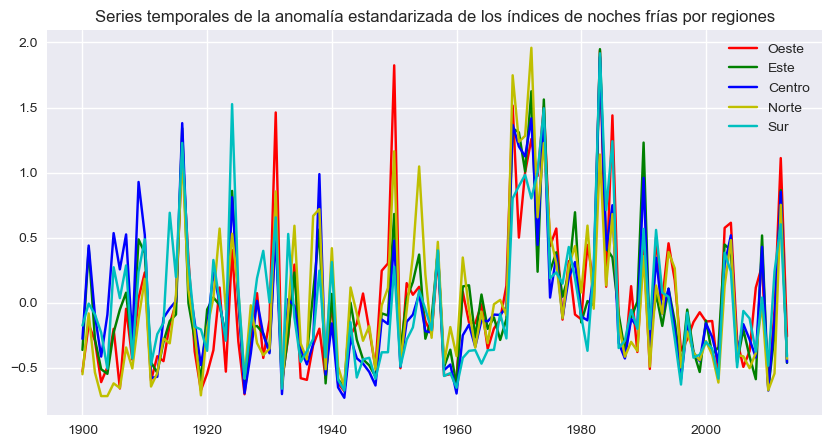

In [79]:
years=np.arange(1900,2014)
fig=plt.figure(figsize=(10,5))
plt.plot(years,oeste_resh_ser_temp_N,'r-',label='Oeste')
plt.plot(years,este_resh_ser_temp_N,'g-',label='Este')
plt.plot(years,centro_resh_ser_temp_N,'b-',label='Centro')
plt.plot(years,norte_resh_ser_temp_N,'y-',label='Norte')
plt.plot(years,sur_resh_ser_temp_N,'c-',label='Sur')
plt.legend()
plt.title('Series temporales de la anomalía estandarizada de los índices de noches frías por regiones')
plt.show()


In [80]:
#veamos si mis índices de cada región se parecen a las PC
PC_corr_OESTE_prim_N=pearsonr(oeste_resh_ser_temp_N,PCs_N[:,0])
print('Correlación entre la primera PC y la el índice del Oeste para noches frías: ',PC_corr_OESTE_prim_N)

PC_corr_ESTE_prim_N=pearsonr(este_resh_ser_temp_N,PCs_N[:,0])
print('Correlación entre la primera PC y la el índice del Este para noches frías: ',PC_corr_ESTE_prim_N)

PC_corr_SUR_prim_N=pearsonr(sur_resh_ser_temp_N,PCs_N[:,0])
print('Correlación entre la primera PC y la el índice del Sur para noches frías: ',PC_corr_SUR_prim_N)

PC_corr_CENTRO_prim_N=pearsonr(centro_resh_ser_temp_N,PCs_N[:,0])
print('Correlación entre la primera PC y la el índice del Centro para noches frías: ',PC_corr_CENTRO_prim_N)

PC_corr_NORTE_prim_N=pearsonr(norte_resh_ser_temp_N,PCs_N[:,0])
print('Correlación entre la primera PC y la el índice del Norte para noches frías: ',PC_corr_NORTE_prim_N)


Correlación entre la primera PC y la el índice del Oeste para noches frías:  (-0.851076733018961, 4.042271159009098e-33)
Correlación entre la primera PC y la el índice del Este para noches frías:  (-0.9570647033591012, 4.598032995752922e-62)
Correlación entre la primera PC y la el índice del Sur para noches frías:  (-0.9175163802962136, 1.1561532461985911e-46)
Correlación entre la primera PC y la el índice del Centro para noches frías:  (-0.9840509585498151, 7.930755811190456e-86)
Correlación entre la primera PC y la el índice del Norte para noches frías:  (-0.8418412193399707, 8.972778357400567e-32)


---

# <CENTER> DÍAS FRÍOS <CENTER>

---

In [81]:
C_D=np.dot(np.transpose(tx10_primavera_sin_nan),tx10_primavera_sin_nan)


In [82]:
eof_tx10,d_tx10,eof2_tx10=linalg.svd(C_D)


In [83]:
fvar_tx10=(d_tx10)/sum(d_tx10)

sum(fvar_tx10[:10])

0.8869206222521071

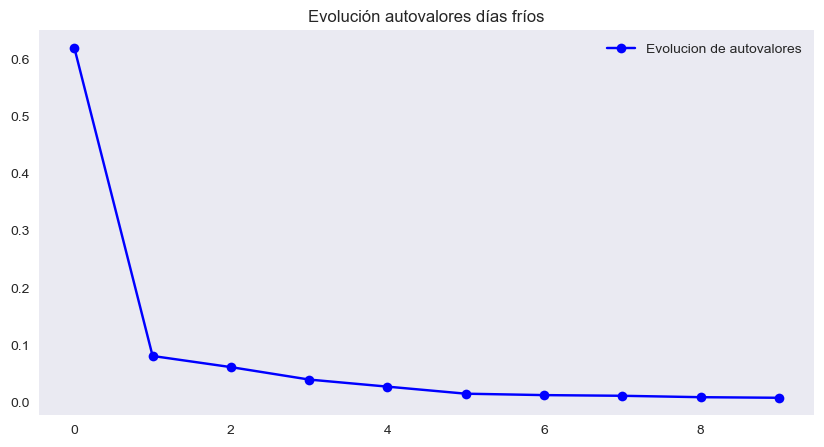

In [84]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar_tx10[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.title('Evolución autovalores días fríos')
plt.legend()
plt.grid()

In [85]:
PC_D=np.dot(tx10_primavera_sin_nan,eof_tx10[:,:4])
PC_D.shape

(114, 4)

In [86]:
PCs_D=(PC_D-np.mean(PC_D))/np.std(PC_D)

Text(0.5, 1.0, 'Días fríos: Primera componente principal fvar=0.55')

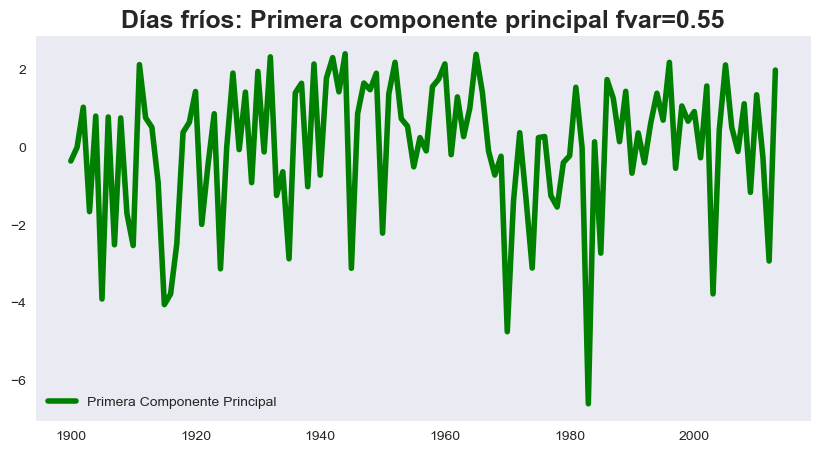

In [87]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs_D[:,0],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Días fríos: Primera componente principal fvar='+ str( round(fvar_tn10[0],2)),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Días fríos: Segunda componente principal fvar=0.1')

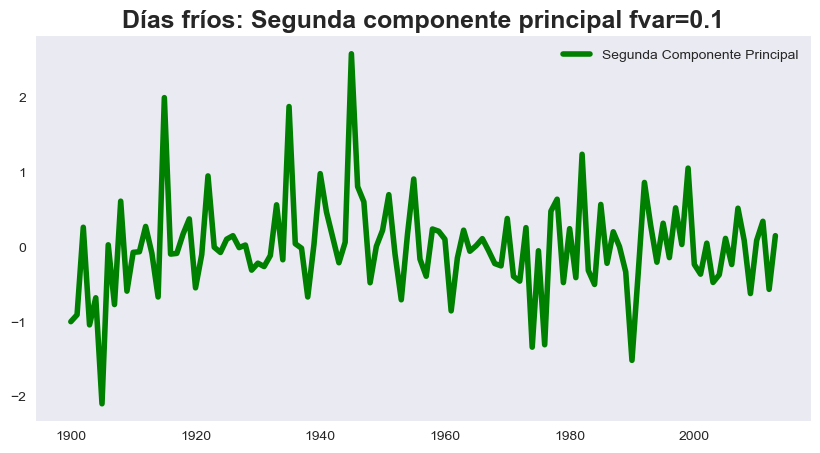

In [88]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs_D[:,1],linewidth= 4,color='green',label='Segunda Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Días fríos: Segunda componente principal fvar='+ str( round(fvar_tn10[1],2)),fontsize=18,weight='bold')


Text(0.5, 1.0, 'Días fríos: Tercera componente principal fvar=0.05')

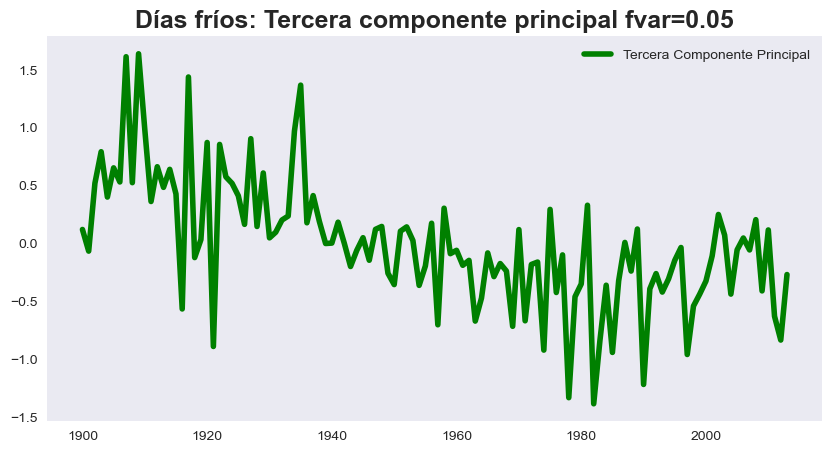

In [89]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs_D[:,2],linewidth= 4,color='green',label='Tercera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Días fríos: Tercera componente principal fvar='+ str( round(fvar_tn10[2],2)),fontsize=18,weight='bold')


In [90]:
nyc=12
n=10
Wn=2*1/nyc
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(b,a,PCs_D[:,0])

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCs_D[:,0])

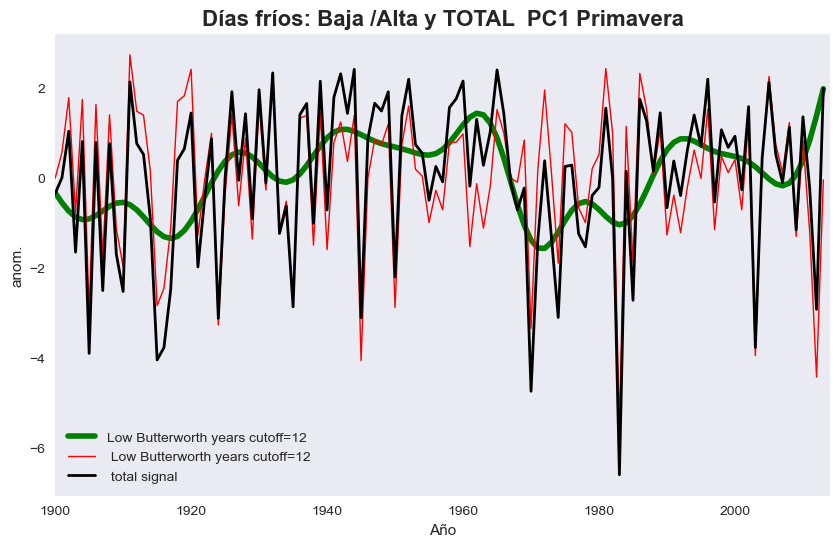

In [91]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Días fríos: Baja /Alta y TOTAL  PC1 Primavera',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom.')
ax.plot(range(1900,2014),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),PCs_D[:,0],linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1900,2014])
ax.legend()
ax.grid()

In [92]:
nyc=12
n=10
Wn=2*1/nyc
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(b,a,PCs_D[:,2])

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCs_D[:,2])

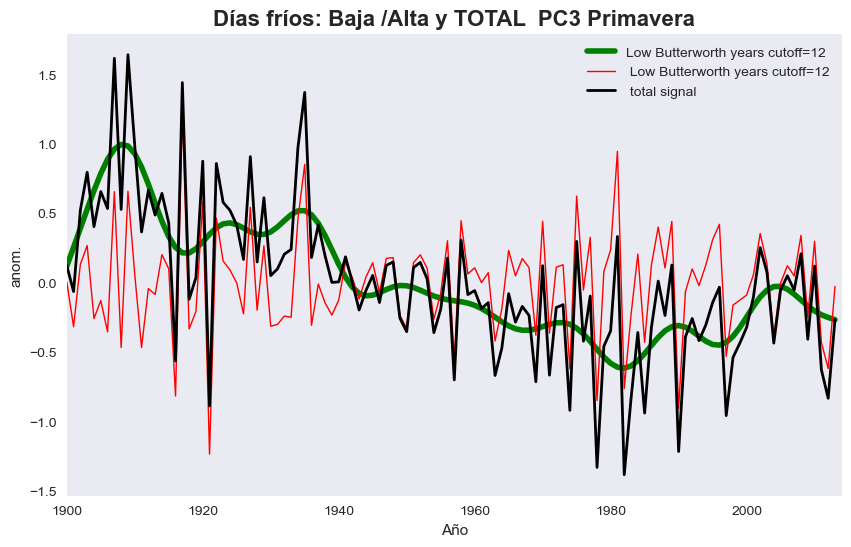

In [93]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Días fríos: Baja /Alta y TOTAL  PC3 Primavera',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom.')
ax.plot(range(1900,2014),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1900,2014),PCs_D[:,2],linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1900,2014])
ax.legend()
ax.grid()

In [94]:
cor1_D,Pvalue1_D,cor_sig1_D,reg1_D,reg1_sig_D=IndexRegrCorr(np.transpose(tx10_primavera_sin_nan),np.transpose(PCs_D[:,0]),0.01,'MonteCarlo',100)
cor2_D,Pvalue2_D,cor_sig2_D,reg2_D,reg2_sig_D=IndexRegrCorr(np.transpose(tx10_primavera_sin_nan),np.transpose(PCs_D[:,1]),0.01,'MonteCarlo',100)
cor3_D,Pvalue3_D,cor_sig3_D,reg3_D,reg3_sig_D=IndexRegrCorr(np.transpose(tx10_primavera_sin_nan),np.transpose(PCs_D[:,2]),0.01,'MonteCarlo',100)


In [95]:
mat_D=np.expand_dims((tx10_primavera)[0],axis=0)

In [96]:
reg1_final_D=pongonans(np.squeeze(reg1_D),mat_D)
reg_sig_1_final_D=pongonans(np.squeeze(reg1_sig_D),mat_D)

cor1_final_D=pongonans(np.squeeze(cor1_D),mat_D)
cor_sig1_final_D=pongonans(np.squeeze(cor_sig1_D),mat_D)

reg2_final_D=pongonans(np.squeeze(reg2_D),mat_D)
reg_sig_2_final_D=pongonans(np.squeeze(reg2_sig_D),mat_D)

cor2_final_D=pongonans(np.squeeze(cor2_D),mat_D)
cor_sig2_final_D=pongonans(np.squeeze(cor_sig2_D),mat_D)

reg3_final_D=pongonans(np.squeeze(reg3_D),mat_D)
reg_sig_3_final_D=pongonans(np.squeeze(reg3_sig_D),mat_D)

cor3_final_D=pongonans(np.squeeze(cor3_D),mat_D)
cor_sig3_final_D=pongonans(np.squeeze(cor_sig3_D),mat_D)

In [97]:
lon = tx10_remallado.lon
lat = tx10_remallado.lat
time=tx10_remallado.time

nlon=lon.shape[0]
nlat=lat.shape[0]
nt=time.shape[0]

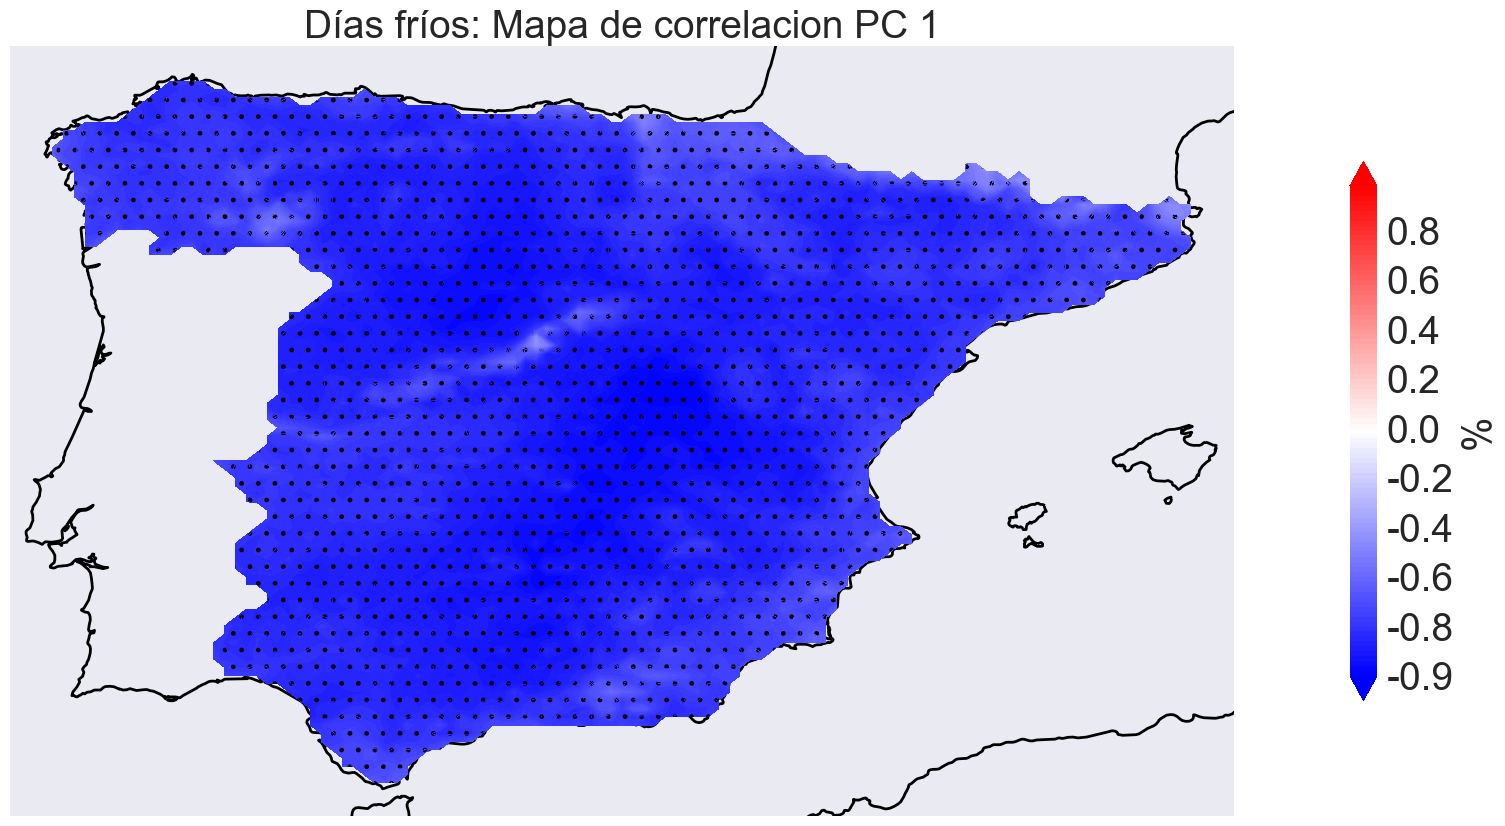

In [98]:
rango_reg=max(abs(np.nanmin(cor1_final_D)),abs(np.nanmax(cor1_final_D)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(cor1_final_D,(nlat,nlon)),lon,lat,levels,'bwr','%','Días fríos: Mapa de correlacion PC 1', ax)
ax.contourf(lon,lat,np.reshape(cor_sig1_final_D,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

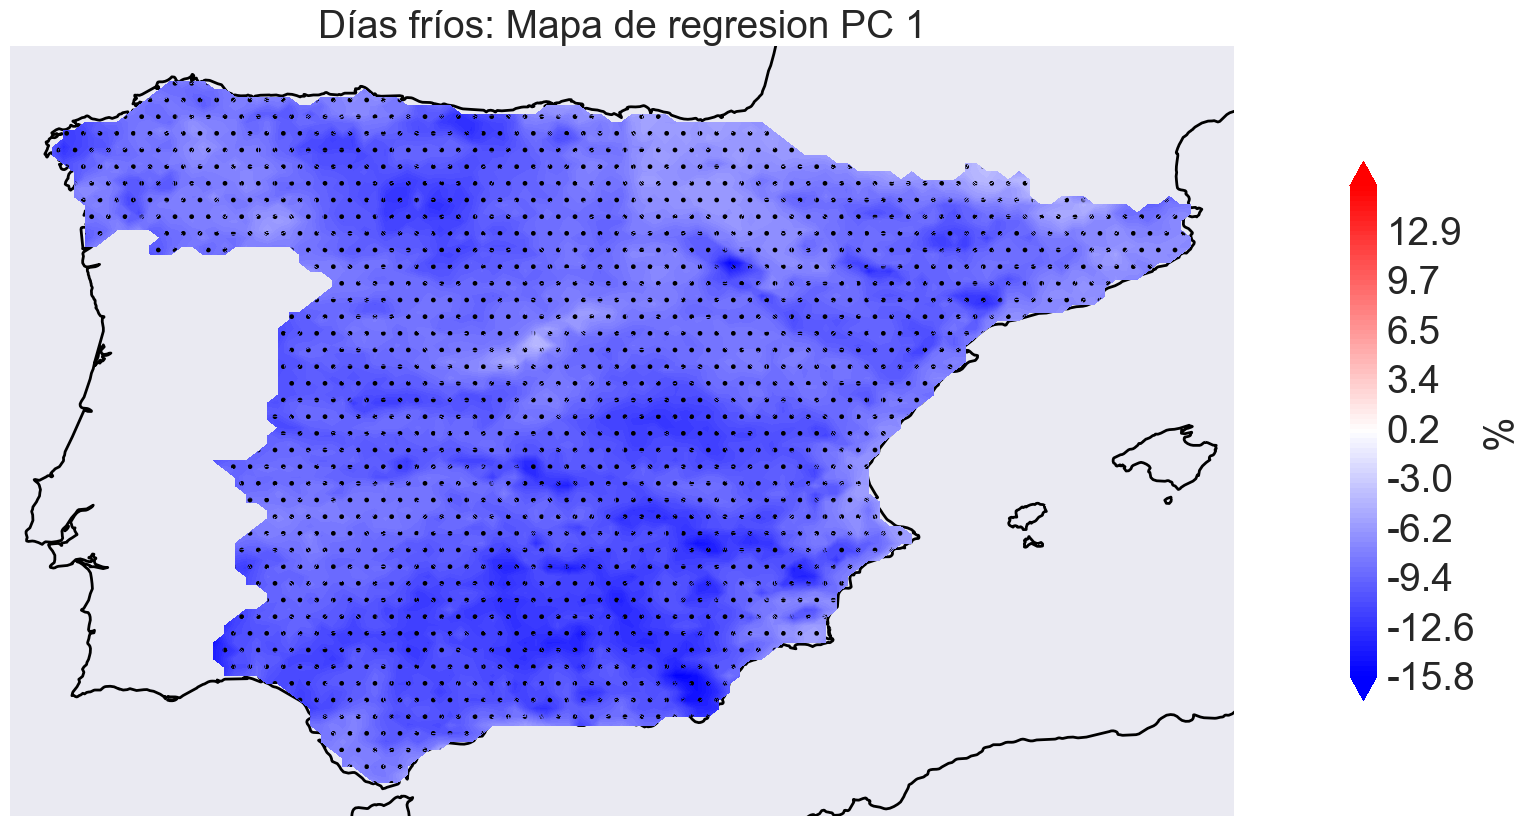

In [99]:
rango_reg=max(abs(np.nanmin(reg1_final_D)),abs(np.nanmax(reg1_final_D)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1_final_D,(nlat,nlon)),lon,lat,levels,'bwr','%','Días fríos: Mapa de regresion PC 1', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_1_final_D,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

(-0.9990479321284396, 3.374975562184333e-154)


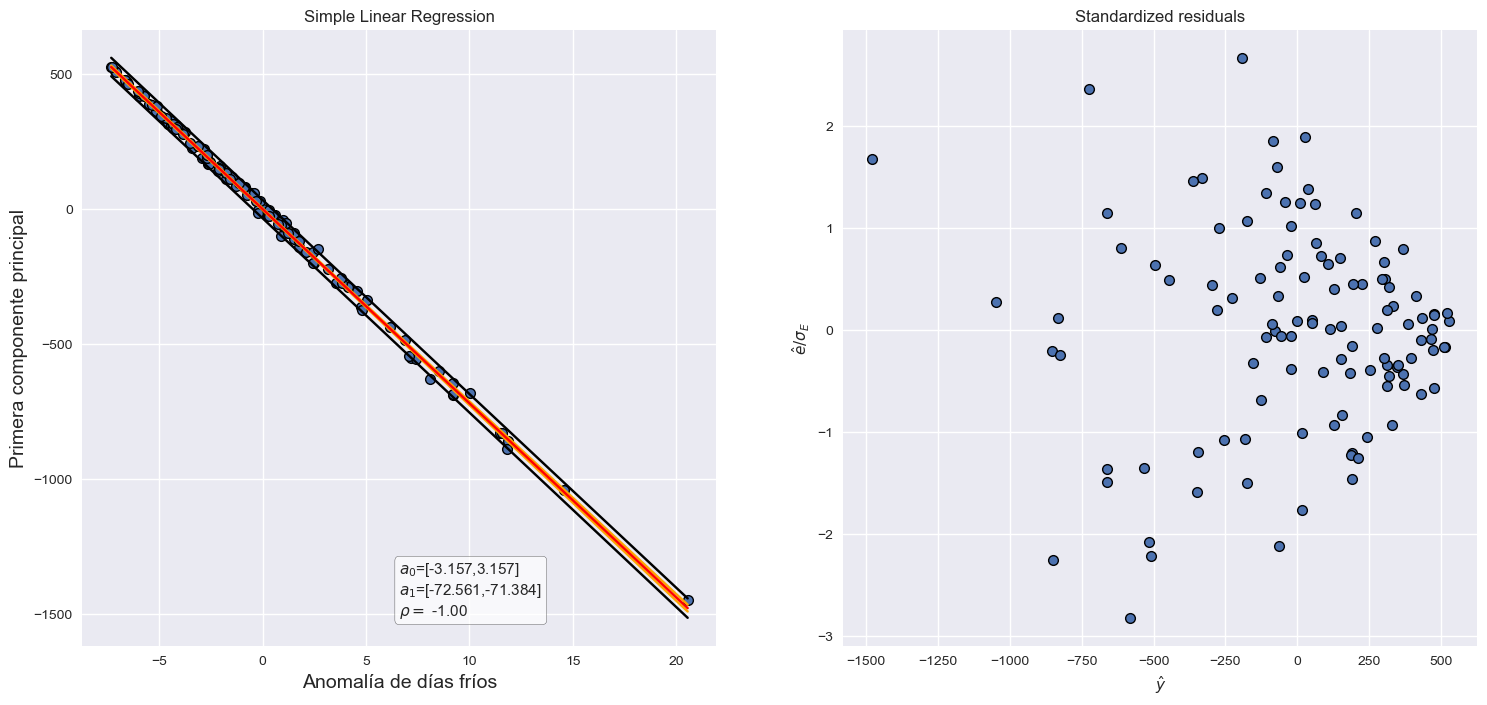

In [100]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(np.nanmean(tx10_primavera_anomalia,axis=(1,2)),PC_D[:,0])
ax[0].set_xlabel('Anomalía de días fríos',size=14)
ax[0].set_ylabel('Primera componente principal',size=14)
print(pearsonr(np.nanmean(tx10_primavera_anomalia,axis=(1,2)),PCs_D[:,0]))

Text(0.5, 1.0, 'Serie anomalías de días fríos (primavera)')

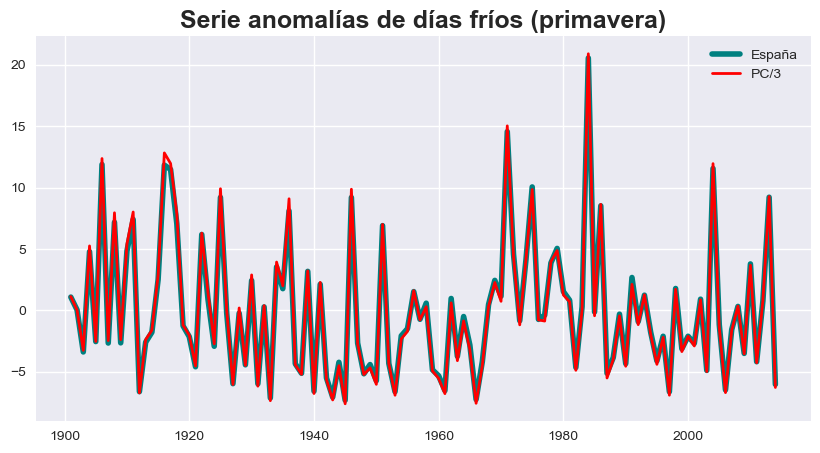

In [101]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1901,2014+1),np.nanmean(tx10_primavera_anomalia,axis=(1,2)),linewidth= 4,color='teal',label='España')

var = np.nanmean(np.squeeze(reg1_final_D))

ax.plot(range(1901,2014+1),PCs_D[:,0]*var/3,linewidth= 2,color='r',label='PC/3')


ax.legend()
ax.set_title('Serie anomalías de días fríos (primavera)',fontsize=18,weight='bold')

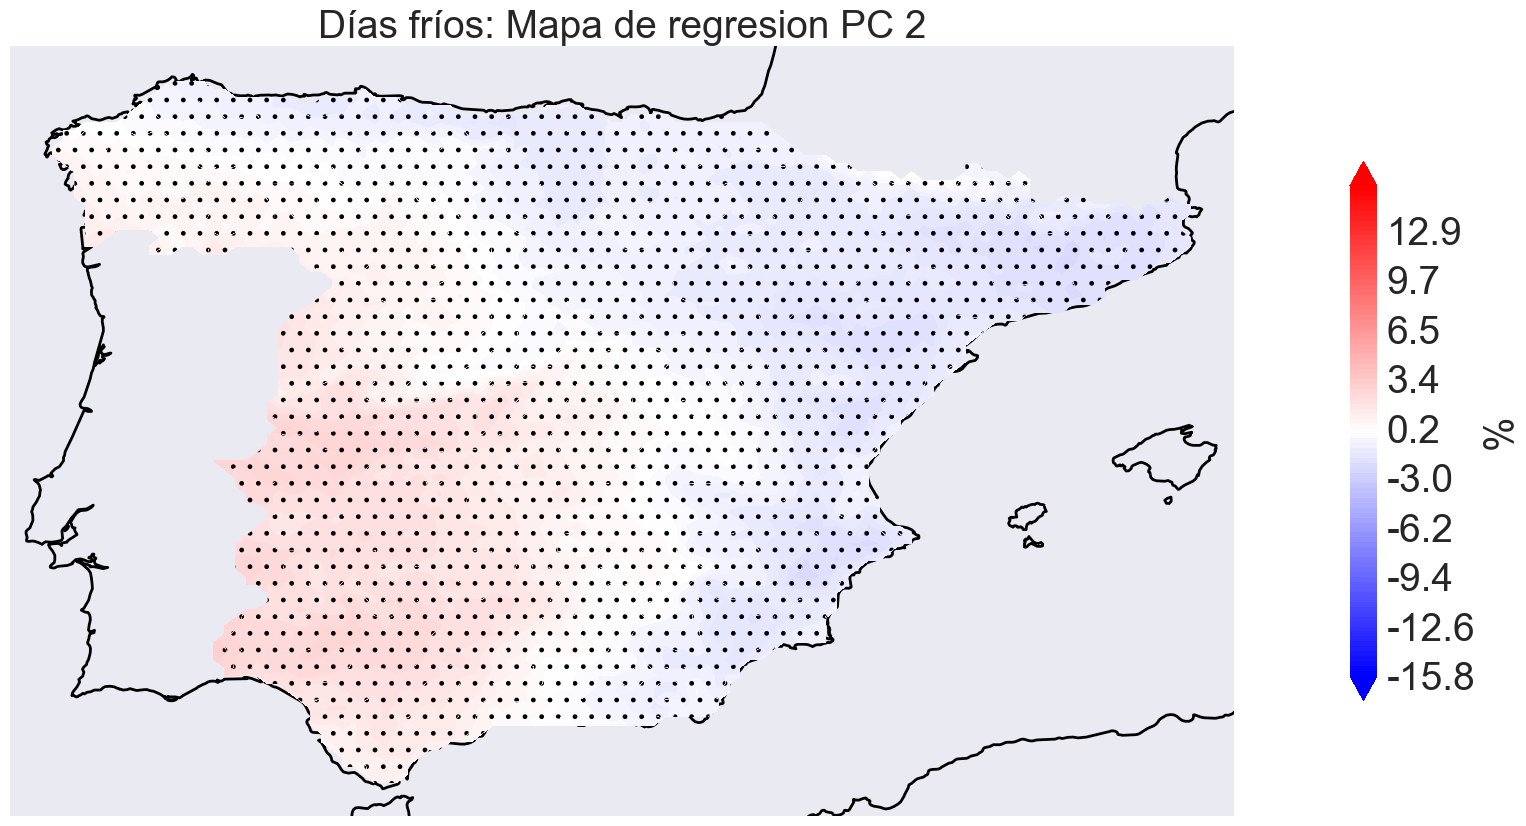

In [102]:
rango_reg=max(abs(np.nanmin(reg1_final_D)),abs(np.nanmax(reg1_final_D)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg2_final_D,(nlat,nlon)),lon,lat,levels,'bwr','%','Días fríos: Mapa de regresion PC 2', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_2_final_D,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')
  

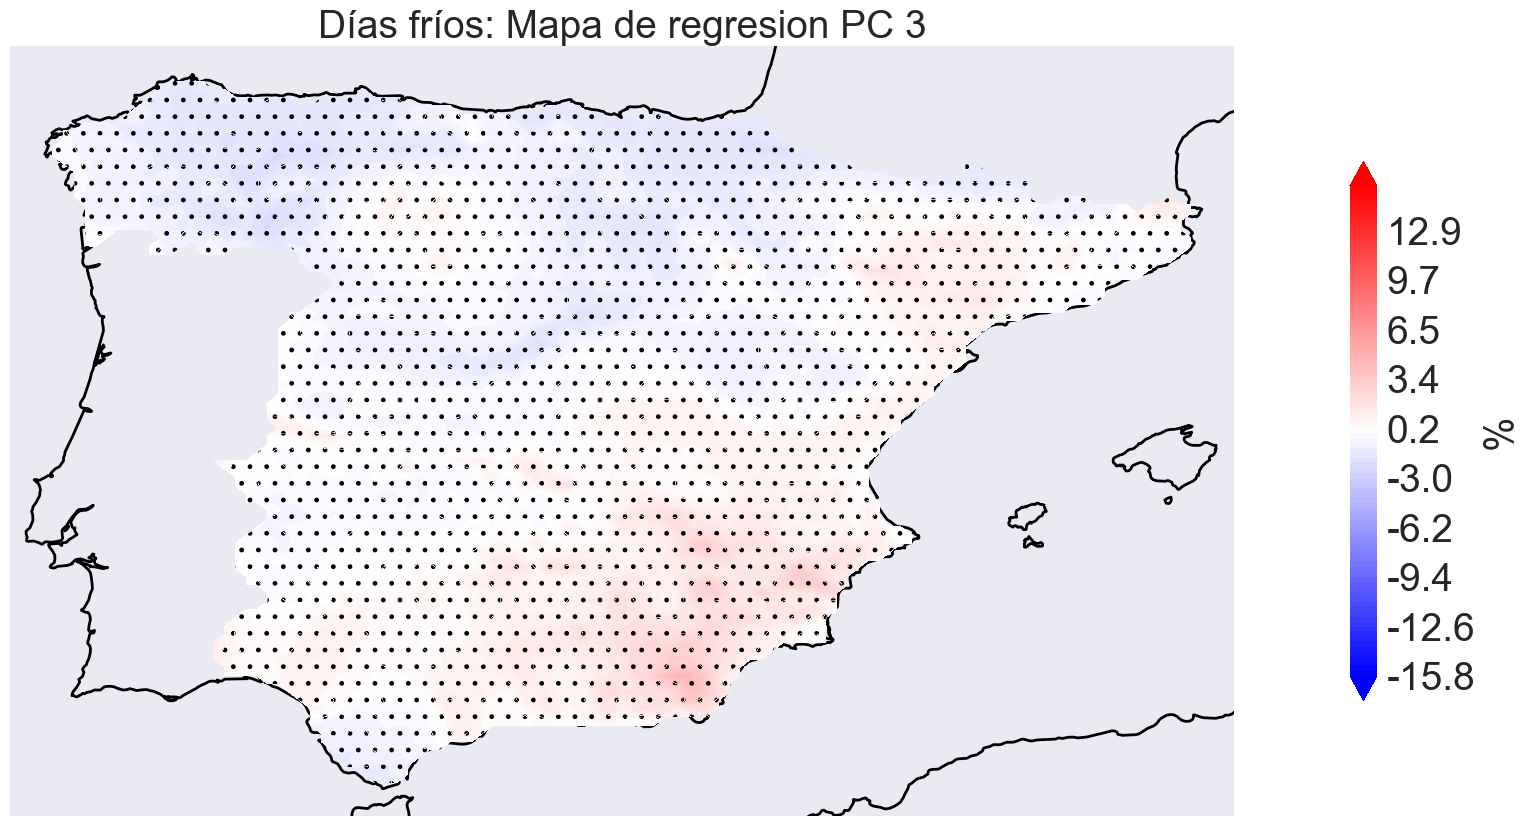

In [103]:
rango_reg=max(abs(np.nanmin(reg1_final_D)),abs(np.nanmax(reg1_final_D)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg3_final_D,(nlat,nlon)),lon,lat,levels,'bwr','%','Días fríos: Mapa de regresion PC 3', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_3_final_D,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')

In [104]:
picos_dias_frios=np.where(PCs_D[:,0]<-4)[0]
pico_dias_1916=picos_dias_frios[0]
pico_dias_1971=picos_dias_frios[1]
pico_dias_1984=picos_dias_frios[2]
picos_dias_frios

array([15, 70, 83])

In [105]:
picos_dias_calidos=np.where(PCs_D[:,0]>2.14)[0]
pico_dias_calidos_1997=picos_dias_frios[-1]
picos_dias_calidos

array([32, 42, 44, 52, 65, 96])

# Reconstruimos años

Vamos a reconstruir al igual que en el caso de noches frías, los años 1997 y 1984


Text(0.5, 1.0, 'Días fríos: Reconstrucción del índice con PC1, año: 1997')

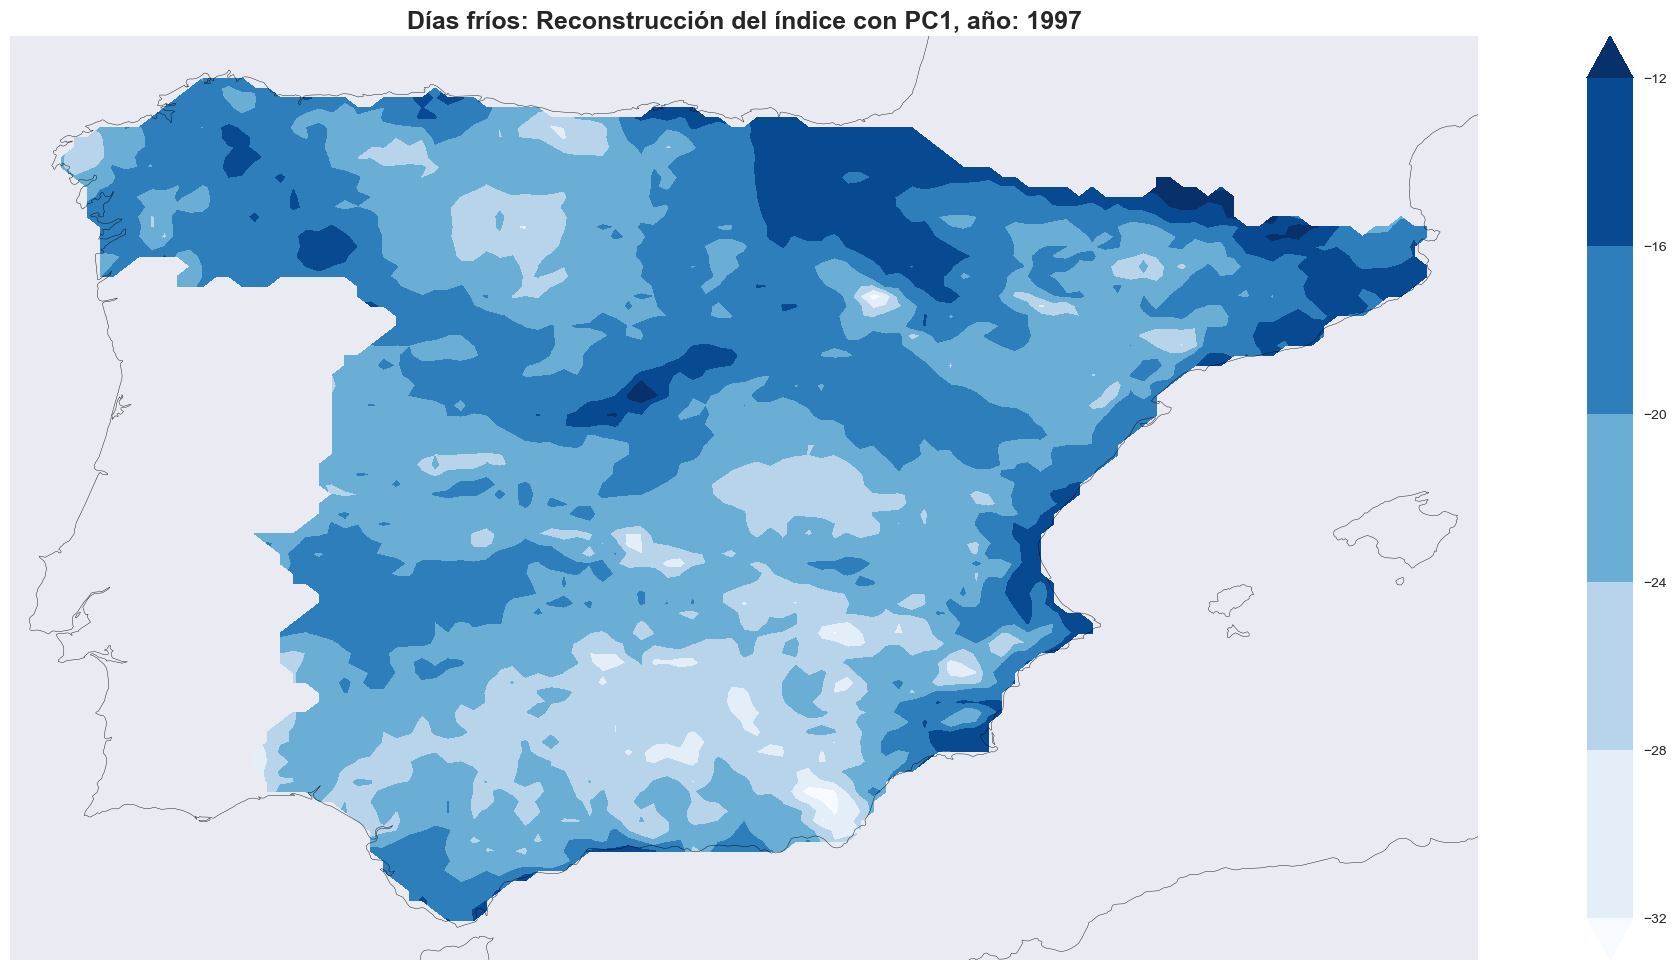

In [106]:
yrss=np.linspace(1901,2014,114)
year1997=1997
yr1997_D=reg1_final_D*PCs_D[yrss==year1997,0]

rango_reg=max(abs(np.nanmin(yr1997_D)),abs(np.nanmax(yr1997_D)))
levels=np.linspace(-rango_reg,rango_reg,10)

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,yr1997_D.reshape(len(lat),len(lon)),cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Días fríos: Reconstrucción del índice con PC1, año: '+str(year1997),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Días fríos: Reconstrucción del índice con PC1, año: 1984')

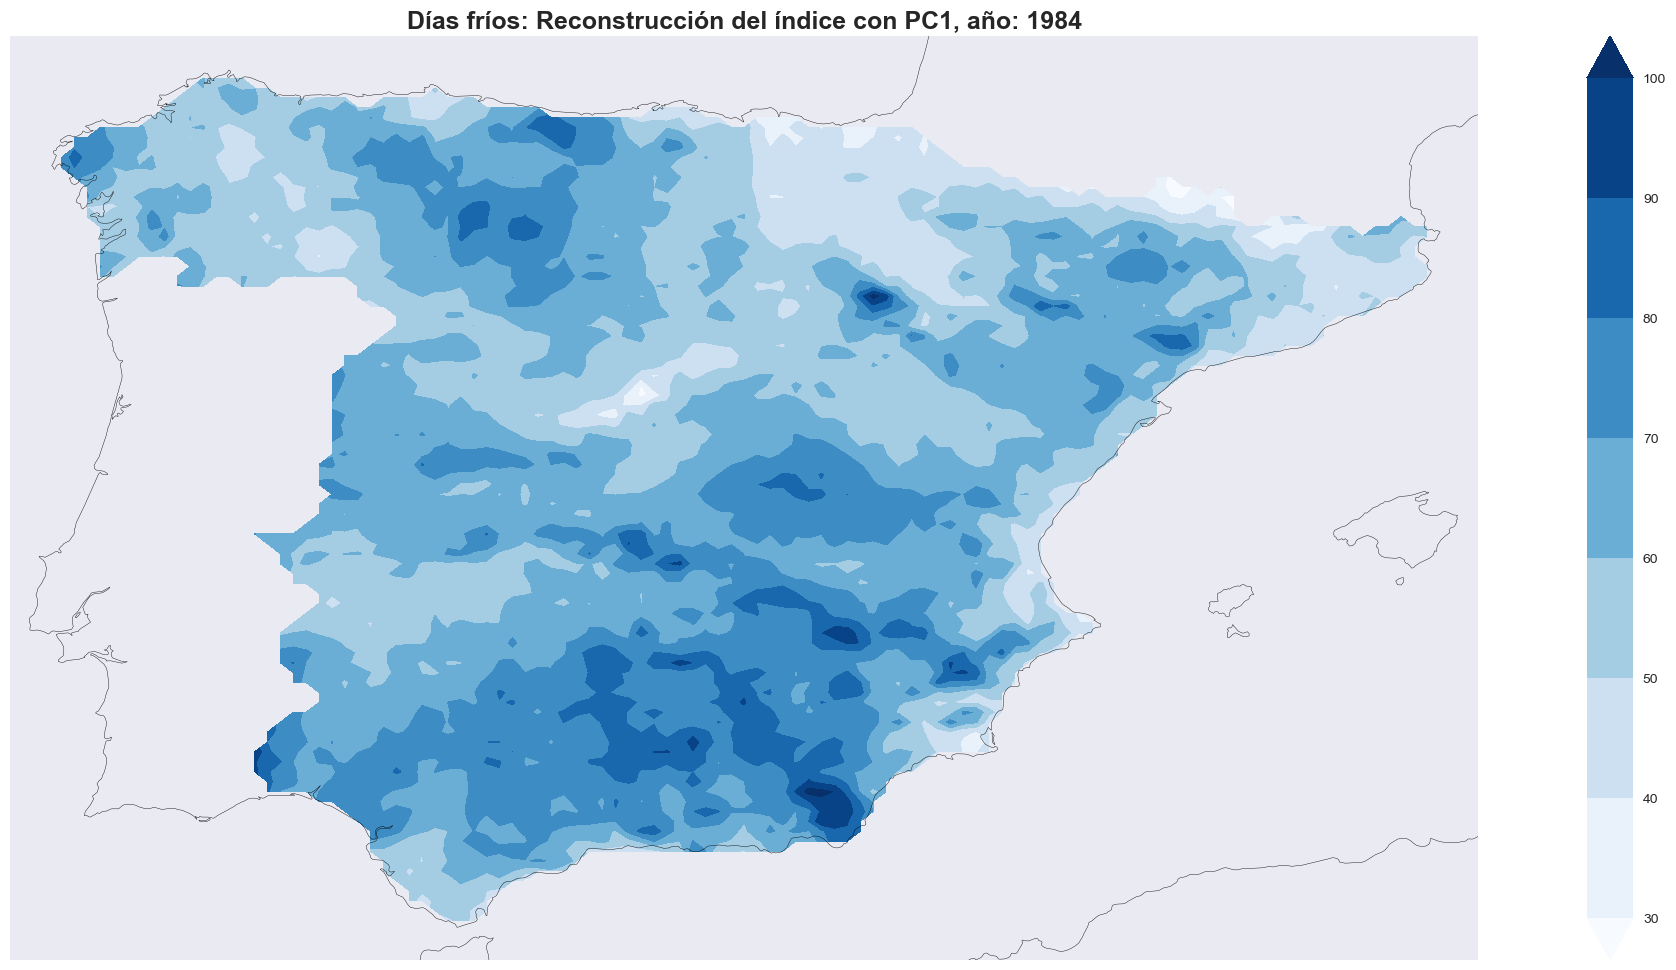

In [107]:
year1984=1984
Yreconst_D=reg1_final_D*PCs_D[yrss==year1984,0]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Yreconst_D.reshape(len(lat),len(lon)),cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Días fríos: Reconstrucción del índice con PC1, año: '+str(year1984),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Días fríos: Reconstrucción del índice con PC1+PC2+PC3, año: 1984')

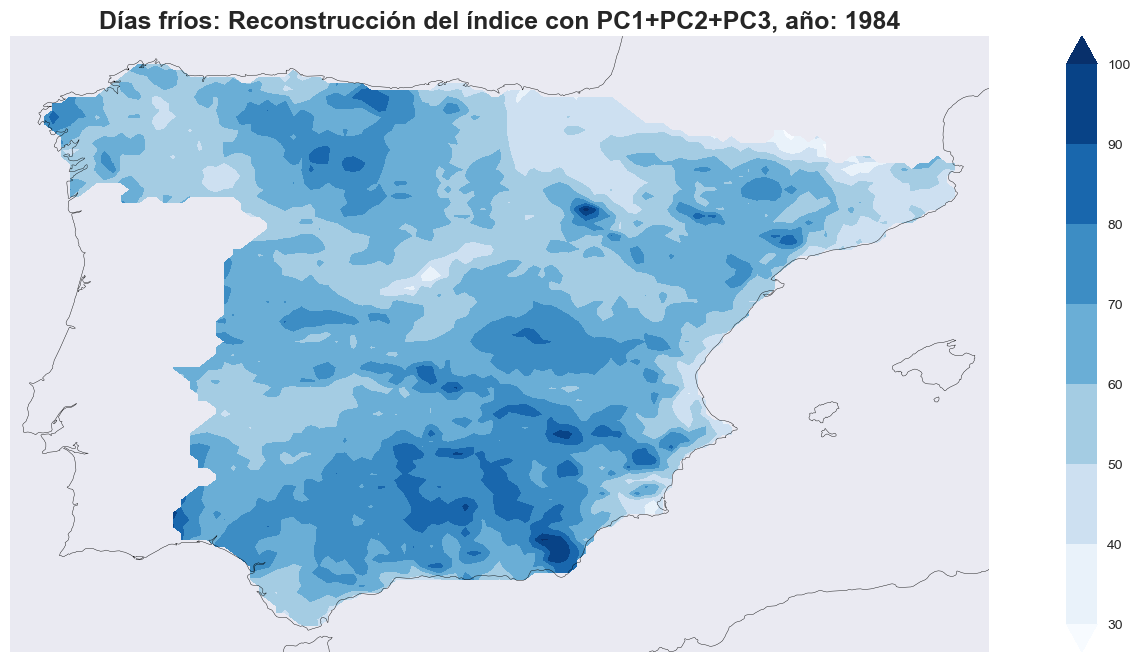

In [108]:
Yreconst_varios_D=reg1_final_D*PCs_D[yrss==year1984,0]+reg2_final_D*PCs_D[yrss==year1984,1]+reg3_final_D*PCs_D[yrss==year1984,2]
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,Yreconst_varios_D.reshape(len(lat),len(lon)),cmap='Blues',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Días fríos: Reconstrucción del índice con PC1+PC2+PC3, año: '+str(year1984),fontsize=18,weight='bold')

## Ahora representaremos las anmomalías de los años 1997 y 1984

Text(0.5, 1.0, 'Días fríos: Anomalía, año: 1997')

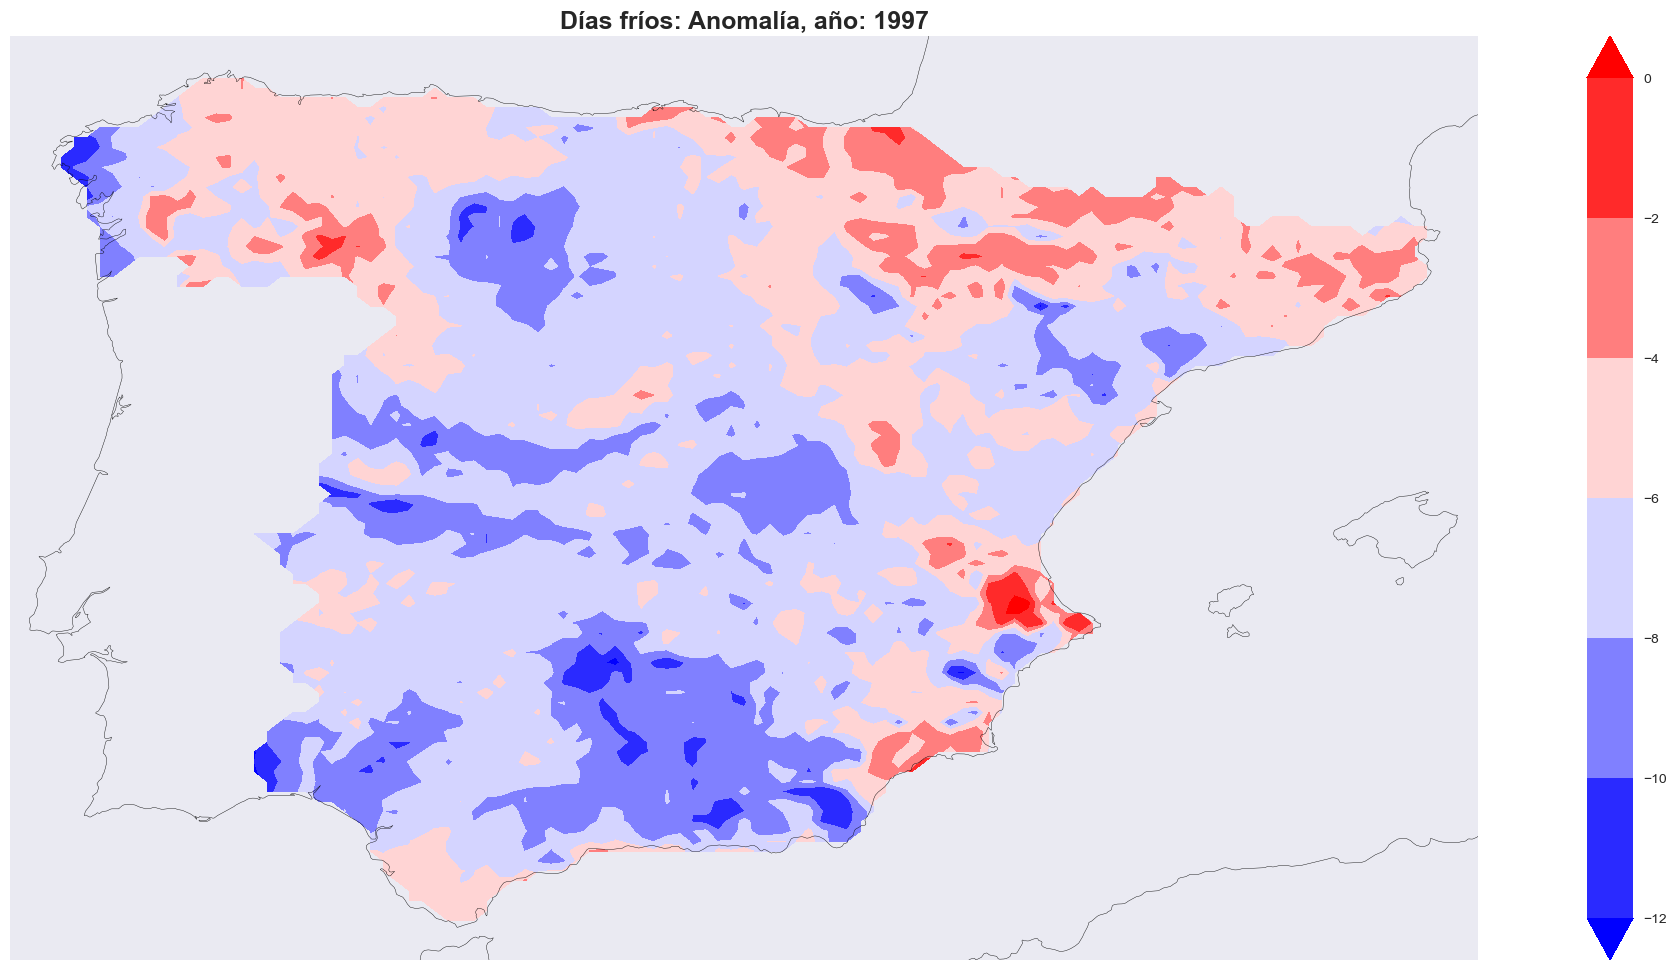

In [109]:
year1997=1997
yr1997_D=tx10_primavera_anomalia[yrss==year1997]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,yr1997_D.reshape(len(lat),len(lon)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Días fríos: Anomalía, año: '+str(year1997),fontsize=18,weight='bold')

Text(0.5, 1.0, 'Días fríos: Anomalía, año: 1984')

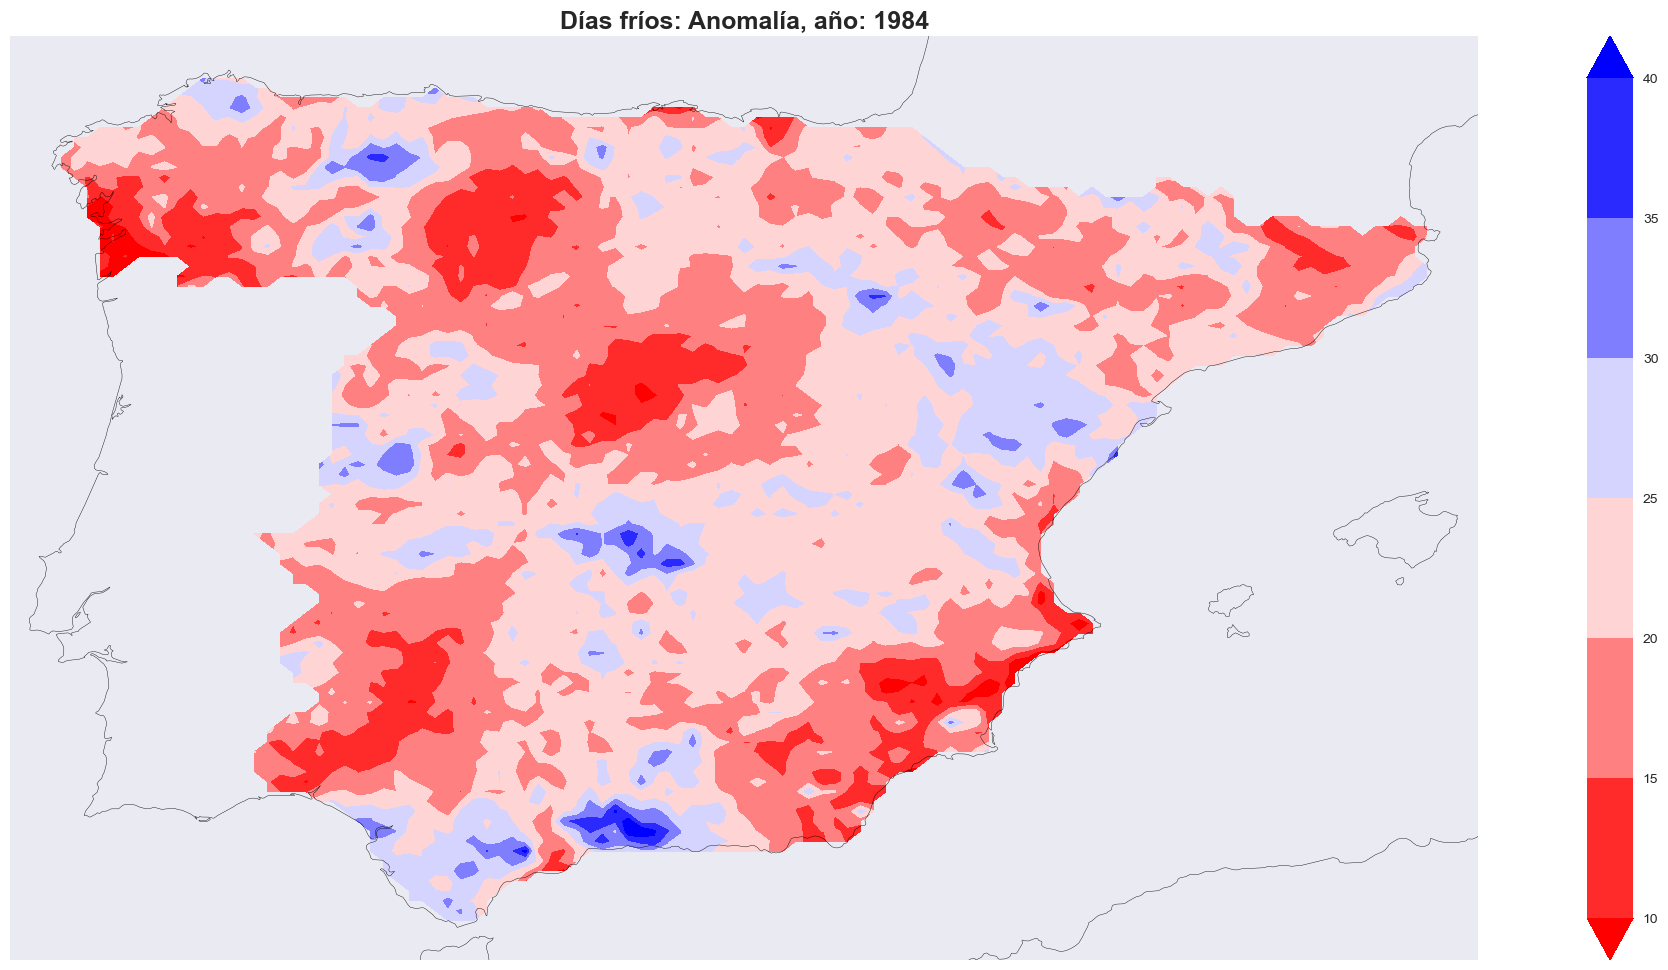

In [110]:
year1984=1984
yr1984_D=tx10_primavera_anomalia[yrss==year1984]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon,lat,yr1984_D.reshape(len(lat),len(lon)),cmap='bwr_r',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Días fríos: Anomalía, año: '+str(year1984),fontsize=18,weight='bold')

### ¿Cómo se relacionan las EOFs con los índices de las diferntes regiones y con los índices de El Niño, la NAO, y las PCS de la SST y la SLP?

In [111]:
#veamos si mi indice DE EL NIÑO EN PRIMAVERA se parece a la eof
primavera_nino_red= primavera_nino[(primavera_nino.time.dt.year<=2000)&(primavera_nino.time.dt.year>=1985)]
primavera_nino_red_reshape=np.reshape(np.asarray(primavera_nino_red),(int(primavera_nino_red.shape[0]/3),3)).mean(axis=1)

A=primavera_nino_red_reshape
PC1_1900_2010____NINO_PC_D=PCs_D[85:101:,0]
PC_corr_Nino_D=pearsonr(A,PC1_1900_2010____NINO_PC_D)
print('Correlación entre la primera PC y el Niño para días fríos: ',PC_corr_Nino_D)

Correlación entre la primera PC y el Niño para días fríos:  (0.04024611695976463, 0.882354964828664)


In [112]:
#veamos si mi indice DE LA NAO EN PRIMAVERA se parece a la eof
primavera_NAO_red= primavera_NAO[(primavera_NAO.time.dt.year<=2000)&(primavera_NAO.time.dt.year>=1985)]
primavera_NAO_red_reshape=np.reshape(np.asarray(primavera_NAO_red),(int(primavera_NAO_red.shape[0]/3),3)).mean(axis=1)

A=primavera_NAO_red_reshape
PC1_1985_2000____NAO_PC_D=PCs_D[85:101,0]
PC_corr_NAO_D=pearsonr(A,PC1_1985_2000____NAO_PC_D)
print('Correlación entre la primera PC y la NAO para días fríos: ',PC_corr_NAO_D)

Correlación entre la primera PC y la NAO para días fríos:  (0.07518046944972685, 0.7819957472645525)


In [113]:
tx10_primavera_anomalia_std= (tx10_primavera-tx10_primavera.mean(axis=0))/np.std(tx10_primavera,axis=0)

In [114]:
lat_oeste_primavera, lon_oeste_primavera, oeste_primavera_D=region(tx10_primavera_anomalia_std,lon,lat,oeste[1][0],oeste[1][1],oeste[0][1],oeste[0][0])
lat_sur_primavera, lon_sur_primavera, sur_primavera_D=region(tx10_primavera_anomalia_std,lon,lat,sur[1][0],sur[1][1],sur[0][1],sur[0][0])
lat_centro_primavera, lon_centro_primavera, centro_primavera_D=region(tx10_primavera_anomalia_std,lon,lat,centro[1][0],centro[1][1],centro[0][1],centro[0][0])
lat_norte_primavera, lon_norte_primavera, norte_primavera_D=region(tx10_primavera_anomalia_std,lon,lat,norte[1][0],norte[1][1],norte[0][1],norte[0][0])
lat_este_primavera, lon_este_primavera, este_primavera_D=region(tx10_primavera_anomalia_std,lon,lat,este[1][0],este[1][1],este[0][1],este[0][0])
oeste_primavera_D.shape

(342, 20, 26)

In [115]:
oeste_resh_D=np.reshape(np.array(oeste_primavera_D), (int(oeste_primavera_D.shape[0]/3),3,lat_oeste_primavera.size,lon_oeste_primavera.size)).mean(axis=1)
oeste_resh_D=np.reshape(oeste_resh_D,(int(oeste_resh_D.shape[0]),(lat_oeste_primavera.size*lon_oeste_primavera.size)))
oeste_resh_ser_temp_D=np.nanmean(oeste_resh_D,axis=1)

sur_resh_D=np.reshape(np.array(sur_primavera_D), (int(sur_primavera_D.shape[0]/3),3,lat_sur_primavera.size,lon_sur_primavera.size)).mean(axis=1)
sur_resh_D=np.reshape(sur_resh_D,(int(sur_resh_D.shape[0]),(lat_sur_primavera.size*lon_sur_primavera.size)))
sur_resh_ser_temp_D=np.nanmean(sur_resh_D,axis=1)

centro_resh_D=np.reshape(np.array(centro_primavera_D), (int(centro_primavera_D.shape[0]/3),3,lat_centro_primavera.size,lon_centro_primavera.size)).mean(axis=1)
centro_resh_D=np.reshape(centro_resh_D,(int(centro_resh_D.shape[0]),(lat_centro_primavera.size*lon_centro_primavera.size)))
centro_resh_ser_temp_D=np.nanmean(centro_resh_D,axis=1)

norte_resh_D=np.reshape(np.array(norte_primavera_D), (int(norte_primavera_D.shape[0]/3),3,lat_norte_primavera.size,lon_norte_primavera.size)).mean(axis=1)
norte_resh_D=np.reshape(norte_resh_D,(int(norte_resh_D.shape[0]),(lat_norte_primavera.size*lon_norte_primavera.size)))
norte_resh_ser_temp_D=np.nanmean(norte_resh_D,axis=1)

este_resh_D=np.reshape(np.array(este_primavera_D), (int(este_primavera_D.shape[0]/3),3,lat_este_primavera.size,lon_este_primavera.size)).mean(axis=1)
este_resh_D=np.reshape(este_resh_D,(int(este_resh_D.shape[0]),(lat_este_primavera.size*lon_este_primavera.size)))
este_resh_ser_temp_D=np.nanmean(este_resh_D,axis=1)

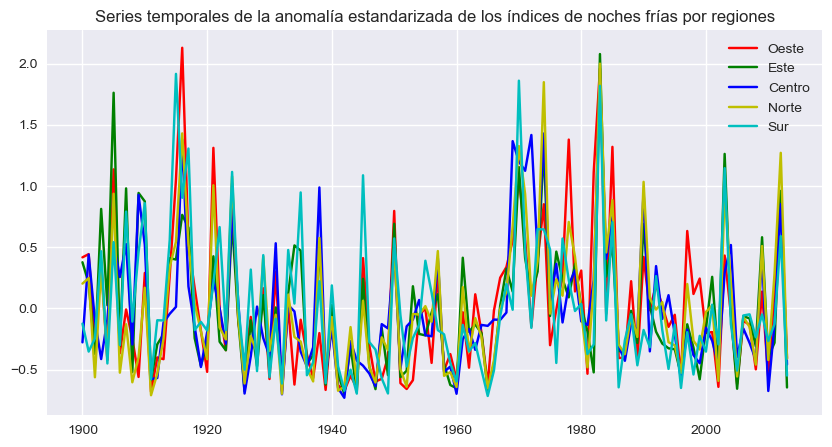

In [116]:
years=np.arange(1900,2014)
fig=plt.figure(figsize=(10,5))
plt.plot(years,oeste_resh_ser_temp_D,'r-',label='Oeste')
plt.plot(years,este_resh_ser_temp_D,'g-',label='Este')
plt.plot(years,centro_resh_ser_temp_N,'b-',label='Centro')
plt.plot(years,norte_resh_ser_temp_D,'y-',label='Norte')
plt.plot(years,sur_resh_ser_temp_D,'c-',label='Sur')
plt.legend()
plt.title('Series temporales de la anomalía estandarizada de los índices de noches frías por regiones')
plt.show()


In [117]:
#veamos si mis índices de cada región se parecen a las PC
PC_corr_OESTE_prim_D=pearsonr(oeste_resh_ser_temp_D,PCs_D[:,0])
print('Correlación entre la primera PC y la el índice del Oeste para noches frías: ',PC_corr_OESTE_prim_D)

PC_corr_ESTE_prim_D=pearsonr(este_resh_ser_temp_D,PCs_D[:,0])
print('Correlación entre la primera PC y la el índice del Este para noches frías: ',PC_corr_ESTE_prim_D)

PC_corr_SUR_prim_D=pearsonr(sur_resh_ser_temp_D,PCs_D[:,0])
print('Correlación entre la primera PC y la el índice del Sur para noches frías: ',PC_corr_SUR_prim_D)

PC_corr_CENTRO_prim_D=pearsonr(centro_resh_ser_temp_D,PCs_D[:,0])
print('Correlación entre la primera PC y la el índice del Centro para noches frías: ',PC_corr_CENTRO_prim_D)

PC_corr_NORTE_prim_D=pearsonr(norte_resh_ser_temp_D,PCs_D[:,0])
print('Correlación entre la primera PC y la el índice del Norte para noches frías: ',PC_corr_NORTE_prim_D)


Correlación entre la primera PC y la el índice del Oeste para noches frías:  (-0.8321999522197594, 1.859069785886601e-30)
Correlación entre la primera PC y la el índice del Este para noches frías:  (-0.9052085744781738, 1.970724329388878e-43)
Correlación entre la primera PC y la el índice del Sur para noches frías:  (-0.9288236384129483, 4.121062729795221e-50)
Correlación entre la primera PC y la el índice del Centro para noches frías:  (-0.9799251876796926, 2.7914287691928442e-80)
Correlación entre la primera PC y la el índice del Norte para noches frías:  (-0.8468152888414254, 1.7332452423898857e-32)


---